# Text Conditioning with CLIP and Cross-Attention

In the previous notebook, we controlled generation with **discrete class labels** (0-9 for digits). This required a fixed vocabulary and a simple embedding table. Now we move to **natural language conditioning** - the ability to say "a photo of a cat" and generate a cat.

This is how modern text-to-image models like Stable Diffusion, DALL-E, and Midjourney work.

## The Evolution of Conditioning

| Notebook | Conditioning | Example | Mechanism |
|----------|-------------|---------|------------|
| Flow Matching, DiT | None | Generate any image | - |
| Class Conditioning | Class label | "Generate digit 7" | $c = h_t + e(y)$ |
| **This Notebook** | Text prompt | "a photo of a cat" | Cross-attention to CLIP |

## The Mathematical Challenge

We need to learn a text-conditional velocity field:

$$v_\theta(x_t, t, \text{text}) : \mathbb{R}^{C \times H \times W} \times [0,1] \times \text{String} \to \mathbb{R}^{C \times H \times W}$$

But "String" isn't a mathematical object. We need to convert text to vectors.

## Why Cross-Attention?

In the previous notebook, we simply added the class embedding to the timestep embedding:

$$c = h_t + e(y) \in \mathbb{R}^D$$

This works for **single tokens** (class labels), but text has **multiple tokens**. We need a mechanism that:

1. Handles variable-length sequences
2. Allows different image regions to focus on different words
3. Preserves the full information in each token

**Cross-attention** provides all of this.

## What We'll Learn

1. **CLIP Text Encoder** - How text becomes vectors
2. **Cross-Attention** - How image patches attend to text tokens
3. **Text-Conditional DiT** - The full architecture
4. **CFG for Text** - Classifier-free guidance with prompts

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Step 1: CLIP - The Bridge Between Text and Images

CLIP (Contrastive Language-Image Pre-training) is a model trained on 400M image-text pairs to learn a shared embedding space.

### The CLIP Training Objective

Given a batch of $N$ image-text pairs, CLIP learns to:

1. **Maximize** similarity between matching pairs
2. **Minimize** similarity between non-matching pairs

$$\mathcal{L}_{\text{CLIP}} = -\frac{1}{N}\sum_{i=1}^N \log \frac{\exp(\text{sim}(I_i, T_i)/\tau)}{\sum_{j=1}^N \exp(\text{sim}(I_i, T_j)/\tau)}$$

This creates **visually grounded** text embeddings:

| Property | Meaning | Example |
|----------|---------|--------|
| **Semantic** | Similar meanings → similar vectors | "dog" ≈ "puppy" |
| **Visual** | Vectors encode visual features | "red" encodes color |
| **Compositional** | Combinations work | "blue dog" is meaningful |

### CLIP Text Encoder Architecture

```
Text: "a photo of a cat"
         │
         ▼
    ┌─────────┐
    │ Tokenize│  → ["a", "photo", "of", "a", "cat"]
    └────┬────┘
         │
         ▼
    ┌─────────┐
    │  Embed  │  → [e₁, e₂, e₃, e₄, e₅]
    └────┬────┘
         │
         ▼
    ┌─────────────┐
    │ Transformer │  → 12 layers of self-attention
    └──────┬──────┘
           │
           ▼
    Token Embeddings: Z ∈ R^{M × D}
```

We use the **token embeddings** (not just the pooled output) for cross-attention.

In [2]:
from from_noise_to_images.text_encoder import CLIPTextEncoder

# Load CLIP text encoder
text_encoder = CLIPTextEncoder(
    model_name="openai/clip-vit-base-patch32",
    device=device,
)

print(f"CLIP embedding dimension: {text_encoder.embed_dim}")
print(f"Max sequence length: {text_encoder.max_length}")

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP embedding dimension: 512
Max sequence length: 77


Token embeddings shape: torch.Size([5, 77, 512])
  → (batch_size, max_length, embed_dim)
Pooled embeddings shape: torch.Size([5, 512])
  → (batch_size, embed_dim)


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

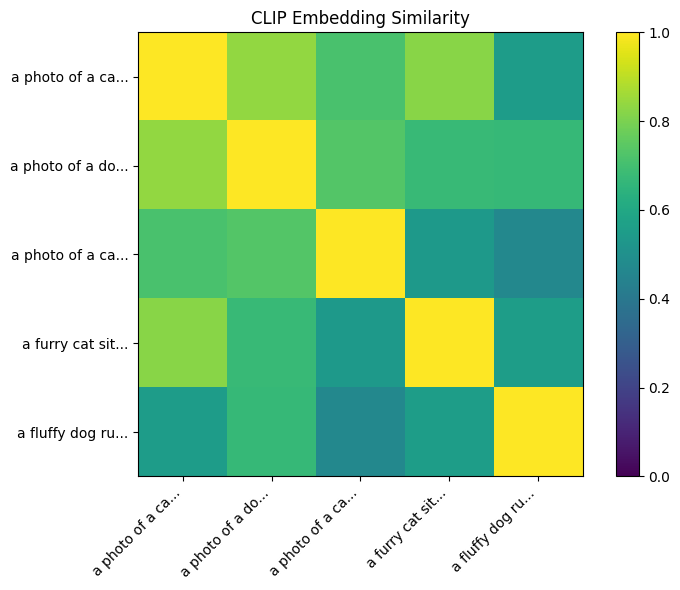


Key Observations:
  - 'cat' prompts are similar to each other
  - 'dog' prompts are similar to each other
  - Both are less similar to 'car'


In [3]:
# Explore CLIP embeddings
prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a furry cat sitting",
    "a fluffy dog running",
]

# Get token embeddings and pooled embeddings
token_embeddings, pooled = text_encoder.encode(prompts, return_pooled=True)

print(f"Token embeddings shape: {token_embeddings.shape}")
print(f"  → (batch_size, max_length, embed_dim)")
print(f"Pooled embeddings shape: {pooled.shape}")
print(f"  → (batch_size, embed_dim)")

# Compute similarity matrix from pooled embeddings
pooled_norm = pooled / pooled.norm(dim=-1, keepdim=True)
similarity = (pooled_norm @ pooled_norm.T).cpu().numpy()

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity, cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(len(prompts)))
ax.set_yticks(range(len(prompts)))
ax.set_xticklabels([p[:15] + "..." for p in prompts], rotation=45, ha='right')
ax.set_yticklabels([p[:15] + "..." for p in prompts])
ax.set_title('CLIP Embedding Similarity')
plt.colorbar(im)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - 'cat' prompts are similar to each other")
print("  - 'dog' prompts are similar to each other")
print("  - Both are less similar to 'car'")

## Step 2: Cross-Attention - Image Patches Attending to Text

Cross-attention allows each image patch to "look at" the text and extract relevant information.

### Mathematical Formulation

Given:
- Image patch embeddings: $X \in \mathbb{R}^{N \times d}$ (N patches)
- Text token embeddings: $Z \in \mathbb{R}^{M \times D}$ (M tokens)

Cross-attention computes:

$$\text{CrossAttn}(X, Z) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V$$

where:
- $Q = X W_Q \in \mathbb{R}^{N \times d_k}$. **Queries** from image patches
- $K = Z W_K \in \mathbb{R}^{M \times d_k}$. **Keys** from text tokens
- $V = Z W_V \in \mathbb{R}^{M \times d_v}$. **Values** from text tokens

### The Attention Matrix

$$A = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) \in \mathbb{R}^{N \times M}$$

Entry $A_{ij}$ represents: "How much should image patch $i$ attend to text token $j$?"

### Intuitive Understanding

For the prompt "a RED dog RUNNING":

```
                    Text Tokens
                 a   RED  dog  RUNNING
              ┌────────────────────────┐
    Patch 1   │ 0.1  0.7  0.1   0.1    │  ← Color region, attends to "RED"
    Patch 2   │ 0.1  0.1  0.6   0.2    │  ← Body region, attends to "dog"
    Patch 3   │ 0.1  0.1  0.3   0.5    │  ← Leg region, attends to "RUNNING"
    Patch 4   │ 0.2  0.3  0.3   0.2    │  ← Background, mixed attention
              └────────────────────────┘
```

### Self-Attention vs Cross-Attention

| Aspect | Self-Attention | Cross-Attention |
|--------|----------------|------------------|
| Q, K, V source | Same sequence (X) | Q from X, K/V from Z |
| Attention shape | $N \times N$ | $N \times M$ |
| Purpose | Patch-to-patch relations | Text-to-image transfer |
| Information flow | Within image | From text to image |

In [4]:
from from_noise_to_images.dit import CrossAttention

# Create a cross-attention layer
embed_dim = 256   # Image patch embedding dimension
context_dim = 512  # CLIP text embedding dimension
num_heads = 8

cross_attn = CrossAttention(
    embed_dim=embed_dim,
    context_dim=context_dim,
    num_heads=num_heads,
).to(device)

# Simulate inputs
batch_size = 2
num_patches = 64  # 8x8 grid
num_tokens = 10   # Text sequence length

# Random image patch embeddings
x = torch.randn(batch_size, num_patches, embed_dim, device=device)

# Random text embeddings (simulating CLIP output)
context = torch.randn(batch_size, num_tokens, context_dim, device=device)

# Forward pass
with torch.no_grad():
    output = cross_attn(x, context)

print(f"Cross-Attention Dimensions:")
print(f"  Image patches (X): {x.shape}")
print(f"  Text tokens (Z):   {context.shape}")
print(f"  Output:            {output.shape}")
print(f"\nThe output has the same shape as the image patches!")
print(f"Each patch now contains information from relevant text tokens.")

Cross-Attention Dimensions:
  Image patches (X): torch.Size([2, 64, 256])
  Text tokens (Z):   torch.Size([2, 10, 512])
  Output:            torch.Size([2, 64, 256])

The output has the same shape as the image patches!
Each patch now contains information from relevant text tokens.


Prompt: 'a red car driving fast'
Tokens: ['[BOS]', 'a</w>', 'red</w>', 'car</w>', 'driving</w>', 'fast</w>', '[EOS]']



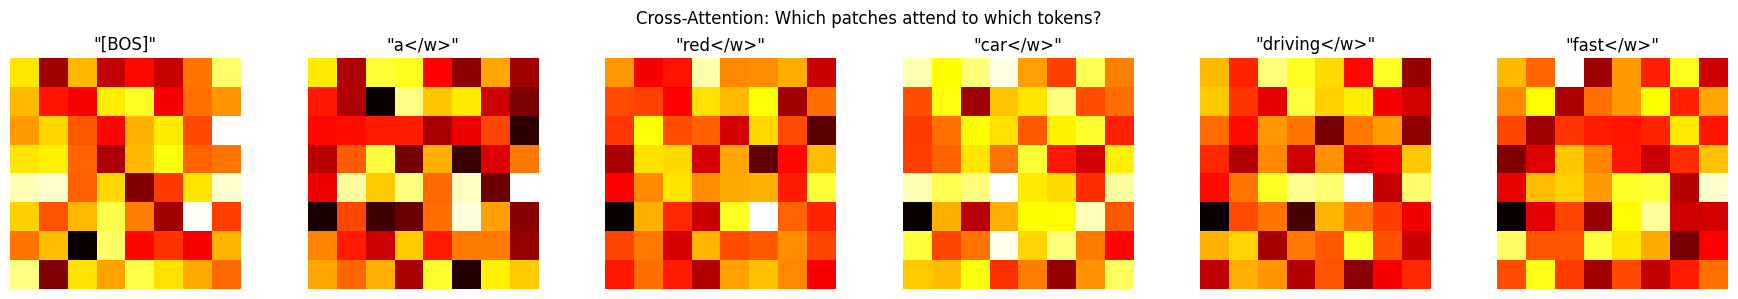

In [5]:
# Visualize attention weights for a real prompt
def visualize_cross_attention_weights(
    cross_attn: CrossAttention,
    x: torch.Tensor,
    context: torch.Tensor,
    tokens: list,
):
    """Visualize what each image patch attends to in the text."""
    B, N, _ = x.shape
    M = context.shape[1]
    H = cross_attn.num_heads
    d = cross_attn.head_dim
    
    with torch.no_grad():
        # Compute Q, K
        q = cross_attn.q_proj(x)
        k = cross_attn.k_proj(context)
        
        # Reshape for attention
        q = q.view(B, N, H, d).transpose(1, 2)
        k = k.view(B, M, H, d).transpose(1, 2)
        
        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * cross_attn.scale
        attn = attn.softmax(dim=-1)  # (B, H, N, M)
    
    # Average over heads and batch
    attn_avg = attn[0].mean(dim=0).cpu().numpy()  # (N, M)
    
    # Reshape to 2D grid (assuming square patches)
    grid_size = int(np.sqrt(N))
    
    # Plot attention for each token
    num_tokens_to_show = min(6, M)
    fig, axes = plt.subplots(1, num_tokens_to_show, figsize=(3*num_tokens_to_show, 3))
    
    for i in range(num_tokens_to_show):
        attn_map = attn_avg[:, i].reshape(grid_size, grid_size)
        axes[i].imshow(attn_map, cmap='hot')
        token = tokens[i] if i < len(tokens) else "[PAD]"
        axes[i].set_title(f'"{token}"')
        axes[i].axis('off')
    
    plt.suptitle('Cross-Attention: Which patches attend to which tokens?', fontsize=12)
    plt.tight_layout()
    plt.show()

# Get real CLIP embeddings
test_prompt = "a red car driving fast"
test_embeddings, test_mask = text_encoder(test_prompt)
test_embeddings = test_embeddings.to(device)

# Get tokens for visualization
tokens = text_encoder.tokenizer.tokenize(test_prompt)
tokens = ['[BOS]'] + tokens + ['[EOS]']

# Random image patches (in practice, these would be from the DiT)
num_patches = 64
x_test = torch.randn(1, num_patches, embed_dim, device=device)

print(f"Prompt: '{test_prompt}'")
print(f"Tokens: {tokens}")
print()

visualize_cross_attention_weights(cross_attn, x_test, test_embeddings, tokens)

## Step 3: Text-Conditional DiT Architecture

The TextConditionalDiT extends our DiT with cross-attention layers.

### Block Structure

Each TextConditionedDiTBlock has three components:

```
                                        Text Embeddings Z
                                              │
                                              ▼
x ─► adaLN ─► Self-Attn ─► + ─► adaLN ─► Cross-Attn ─► + ─► adaLN ─► MLP ─► + ─► out
│                         │   │                        │   │                │
└───────(residual)────────┘   └───────(residual)───────┘   └──(residual)────┘
```

### Mathematical Formulation

Let $x^{(l)}$ be the input to layer $l$, $c$ be timestep conditioning, $Z$ be text embeddings:

$$x^{(l+1/3)} = x^{(l)} + \text{SelfAttn}(\text{adaLN}(x^{(l)}, c))$$
$$x^{(l+2/3)} = x^{(l+1/3)} + \text{CrossAttn}(\text{adaLN}(x^{(l+1/3)}, c), Z)$$
$$x^{(l+1)} = x^{(l+2/3)} + \text{MLP}(\text{adaLN}(x^{(l+2/3)}, c))$$

### Full Architecture

```
Text Prompt                    Noisy Image x_t          Timestep t
     │                              │                       │
     ▼                              ▼                       ▼
┌─────────┐                  ┌───────────┐           ┌───────────┐
│  CLIP   │                  │ Patchify  │           │ Time Emb  │
│ Encoder │                  │ + PosEmb  │           │   (MLP)   │
└────┬────┘                  └─────┬─────┘           └─────┬─────┘
     │                             │                       │
     │ Z ∈ R^{M × D}               │ X ∈ R^{N × d}         │ c ∈ R^{d_c}
     │                             │                       │
     │                             ▼                       │
     │                    ┌─────────────────┐              │
     └───────────────────►│ TextConditioned │◄─────────────┘
                          │    DiT Blocks   │
                          └────────┬────────┘
                                   │
                                   ▼
                          ┌─────────────────┐
                          │   Unpatchify    │
                          └────────┬────────┘
                                   │
                                   ▼
                          Velocity v ∈ R^{C × H × W}
```

### Key Differences from ConditionalDiT

| Aspect | ConditionalDiT | TextConditionalDiT |
|--------|----------------|---------------------|
| Conditioning | Class labels (0-9) | Text prompts |
| Embedding | Learnable table | Frozen CLIP |
| Integration | Added to timestep | Cross-attention |
| Vocabulary | Fixed (10 classes) | Open (any text) |
| Representation | Single vector | Sequence of tokens |

In [6]:
from from_noise_to_images.dit import TextConditionalDiT

# Create the text-conditional DiT for CIFAR-10 (32x32 RGB)
model = TextConditionalDiT(
    img_size=32,          # CIFAR-10 image size
    patch_size=4,         # 4x4 patches → 8x8 = 64 patches
    in_channels=3,        # RGB
    embed_dim=256,        # Patch embedding dimension
    depth=6,              # Number of transformer blocks
    num_heads=8,          # Attention heads
    mlp_ratio=4.0,        # MLP expansion
    context_dim=512,      # CLIP ViT-B/32 embedding dimension
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"TextConditionalDiT Parameters: {num_params:,}")

# Compare to ConditionalDiT
from from_noise_to_images.dit import ConditionalDiT
class_model = ConditionalDiT(img_size=32, patch_size=4, in_channels=3)
class_params = sum(p.numel() for p in class_model.parameters() if p.requires_grad)
print(f"ConditionalDiT Parameters: {class_params:,}")
print(f"Difference: +{num_params - class_params:,} (cross-attention layers)")

TextConditionalDiT Parameters: 18,145,072
ConditionalDiT Parameters: 12,379,440
Difference: +5,765,632 (cross-attention layers)


In [7]:
# Test forward pass
batch_size = 4

# Random noisy images
x = torch.randn(batch_size, 3, 32, 32, device=device)

# Random timesteps
t = torch.rand(batch_size, device=device)

# Text embeddings from CLIP
prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of a plane",
]
text_embeddings, text_mask = text_encoder(prompts)
text_embeddings = text_embeddings.to(device)
text_mask = text_mask.to(device)

# Forward pass
with torch.no_grad():
    v_pred = model(x, t, text_embeddings, text_mask)

print(f"Input shape:       {x.shape}")
print(f"Timesteps shape:   {t.shape}")
print(f"Text embed shape:  {text_embeddings.shape}")
print(f"Text mask shape:   {text_mask.shape}")
print(f"Output shape:      {v_pred.shape}")
print(f"\nModel correctly outputs velocity field with same shape as input!")

Input shape:       torch.Size([4, 3, 32, 32])
Timesteps shape:   torch.Size([4])
Text embed shape:  torch.Size([4, 77, 512])
Text mask shape:   torch.Size([4, 77])
Output shape:      torch.Size([4, 3, 32, 32])

Model correctly outputs velocity field with same shape as input!


## Step 4: Dataset - CIFAR-10 with Text Captions

We'll use CIFAR-10 (32×32 RGB images) with class names converted to captions.

### CIFAR-10 Classes → Captions

| Index | Class | Caption Template |
|-------|-------|------------------|
| 0 | airplane | "a photo of an airplane" |
| 1 | automobile | "a photo of an automobile" |
| 2 | bird | "a photo of a bird" |
| 3 | cat | "a photo of a cat" |
| 4 | deer | "a photo of a deer" |
| 5 | dog | "a photo of a dog" |
| 6 | frog | "a photo of a frog" |
| 7 | horse | "a photo of a horse" |
| 8 | ship | "a photo of a ship" |
| 9 | truck | "a photo of a truck" |

CLIP understands "a photo of a X" format very well from its training.

In [8]:
from from_noise_to_images.text_encoder import make_cifar10_captions

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# Test caption function
sample_labels = torch.tensor([0, 3, 5, 8])
captions = make_cifar10_captions(sample_labels)

print("Label → Caption mapping:")
for label, caption in zip(sample_labels.tolist(), captions):
    print(f"  {label} → '{caption}'")

  0%|                                                                                                    | 0.00/170M [00:00<?, ?B/s]

  0%|                                                                                         | 32.8k/170M [00:00<1:08:43, 41.3kB/s]

  0%|                                                                                         | 65.5k/170M [00:01<1:00:01, 47.3kB/s]

  0%|                                                                                           | 98.3k/170M [00:01<46:59, 60.4kB/s]

  0%|                                                                                            | 131k/170M [00:02<38:28, 73.8kB/s]

  0%|                                                                                            | 164k/170M [00:02<30:12, 94.0kB/s]

  0%|                                                                                             | 197k/170M [00:02<25:07, 113kB/s]

  0%|▏                                                                                            | 229k/170M [00:02<20:24, 139kB/s]

  0%|▏                                                                                            | 262k/170M [00:02<17:16, 164kB/s]

  0%|▏                                                                                            | 295k/170M [00:02<15:08, 187kB/s]

  0%|▏                                                                                            | 328k/170M [00:02<13:30, 210kB/s]

  0%|▏                                                                                            | 360k/170M [00:03<12:40, 224kB/s]

  0%|▏                                                                                            | 426k/170M [00:03<10:24, 273kB/s]

  0%|▎                                                                                            | 492k/170M [00:03<09:15, 306kB/s]

  0%|▎                                                                                            | 557k/170M [00:03<07:57, 356kB/s]

  0%|▎                                                                                            | 623k/170M [00:03<07:42, 368kB/s]

  0%|▍                                                                                            | 688k/170M [00:03<07:01, 403kB/s]

  0%|▍                                                                                            | 754k/170M [00:03<06:32, 432kB/s]

  0%|▍                                                                                            | 819k/170M [00:04<06:06, 463kB/s]

  1%|▍                                                                                            | 885k/170M [00:04<05:47, 487kB/s]

  1%|▌                                                                                            | 950k/170M [00:04<05:34, 507kB/s]

  1%|▌                                                                                           | 1.02M/170M [00:04<05:20, 528kB/s]

  1%|▌                                                                                           | 1.08M/170M [00:04<05:16, 536kB/s]

  1%|▋                                                                                           | 1.18M/170M [00:04<04:48, 588kB/s]

  1%|▋                                                                                           | 1.28M/170M [00:04<04:37, 609kB/s]

  1%|▋                                                                                           | 1.38M/170M [00:04<04:20, 650kB/s]

  1%|▊                                                                                           | 1.47M/170M [00:05<04:08, 680kB/s]

  1%|▊                                                                                           | 1.57M/170M [00:05<03:57, 711kB/s]

  1%|▉                                                                                           | 1.67M/170M [00:05<03:45, 747kB/s]

  1%|▉                                                                                           | 1.77M/170M [00:05<03:43, 754kB/s]

  1%|█                                                                                           | 1.87M/170M [00:05<03:34, 785kB/s]

  1%|█                                                                                           | 1.97M/170M [00:05<03:23, 827kB/s]

  1%|█                                                                                           | 2.06M/170M [00:05<03:24, 825kB/s]

  1%|█▏                                                                                          | 2.16M/170M [00:05<03:17, 853kB/s]

  1%|█▏                                                                                          | 2.29M/170M [00:06<03:06, 900kB/s]

  1%|█▎                                                                                          | 2.39M/170M [00:06<03:05, 906kB/s]

  1%|█▎                                                                                          | 2.52M/170M [00:06<02:58, 941kB/s]

  2%|█▍                                                                                          | 2.65M/170M [00:06<02:53, 965kB/s]

  2%|█▌                                                                                          | 2.79M/170M [00:06<02:51, 978kB/s]

  2%|█▌                                                                                          | 2.92M/170M [00:06<02:48, 993kB/s]

  2%|█▋                                                                                         | 3.05M/170M [00:06<02:46, 1.01MB/s]

  2%|█▋                                                                                          | 3.18M/170M [00:06<02:47, 996kB/s]

  2%|█▊                                                                                         | 3.31M/170M [00:07<02:44, 1.01MB/s]

  2%|█▊                                                                                         | 3.44M/170M [00:07<02:46, 1.00MB/s]

  2%|█▉                                                                                         | 3.57M/170M [00:07<02:45, 1.01MB/s]

  2%|█▉                                                                                         | 3.70M/170M [00:07<02:45, 1.01MB/s]

  2%|██                                                                                         | 3.83M/170M [00:07<02:45, 1.01MB/s]

  2%|██                                                                                         | 3.96M/170M [00:07<02:44, 1.01MB/s]

  2%|██▏                                                                                         | 4.10M/170M [00:07<02:47, 995kB/s]

  2%|██▎                                                                                        | 4.23M/170M [00:07<02:44, 1.01MB/s]

  3%|██▎                                                                                        | 4.36M/170M [00:08<02:43, 1.01MB/s]

  3%|██▍                                                                                         | 4.49M/170M [00:08<02:47, 993kB/s]

  3%|██▍                                                                                        | 4.62M/170M [00:08<02:44, 1.01MB/s]

  3%|██▌                                                                                        | 4.75M/170M [00:08<02:44, 1.01MB/s]

  3%|██▋                                                                                         | 4.88M/170M [00:08<02:47, 992kB/s]

  3%|██▋                                                                                         | 5.01M/170M [00:08<02:46, 992kB/s]

  3%|██▊                                                                                         | 5.14M/170M [00:08<02:48, 982kB/s]

  3%|██▊                                                                                         | 5.28M/170M [00:09<02:47, 988kB/s]

  3%|██▉                                                                                         | 5.41M/170M [00:09<02:45, 997kB/s]

  3%|██▉                                                                                         | 5.54M/170M [00:09<02:46, 989kB/s]

  3%|███                                                                                        | 5.67M/170M [00:09<02:44, 1.00MB/s]

  3%|███▏                                                                                        | 5.80M/170M [00:09<02:44, 998kB/s]

  3%|███▏                                                                                       | 5.93M/170M [00:09<02:44, 1.00MB/s]

  4%|███▏                                                                                       | 6.06M/170M [00:09<02:42, 1.01MB/s]

  4%|███▎                                                                                        | 6.19M/170M [00:09<02:44, 999kB/s]

  4%|███▍                                                                                       | 6.32M/170M [00:10<02:44, 1.00MB/s]

  4%|███▍                                                                                       | 6.46M/170M [00:10<02:41, 1.02MB/s]

  4%|███▌                                                                                        | 6.59M/170M [00:10<02:44, 997kB/s]

  4%|███▌                                                                                       | 6.72M/170M [00:10<02:42, 1.01MB/s]

  4%|███▋                                                                                        | 6.85M/170M [00:10<02:44, 996kB/s]

  4%|███▋                                                                                       | 6.98M/170M [00:10<02:42, 1.01MB/s]

  4%|███▊                                                                                       | 7.11M/170M [00:10<02:40, 1.02MB/s]

  4%|███▊                                                                                       | 7.24M/170M [00:10<02:41, 1.01MB/s]

  4%|███▉                                                                                       | 7.37M/170M [00:11<02:41, 1.01MB/s]

  4%|████                                                                                       | 7.50M/170M [00:11<02:41, 1.01MB/s]

  4%|████                                                                                       | 7.63M/170M [00:11<02:42, 1.00MB/s]

  5%|████▏                                                                                      | 7.77M/170M [00:11<02:40, 1.01MB/s]

  5%|████▎                                                                                       | 7.90M/170M [00:11<02:42, 998kB/s]

  5%|████▎                                                                                      | 8.03M/170M [00:11<02:42, 1.00MB/s]

  5%|████▎                                                                                      | 8.16M/170M [00:11<02:40, 1.01MB/s]

  5%|████▍                                                                                      | 8.29M/170M [00:12<02:41, 1.01MB/s]

  5%|████▍                                                                                      | 8.42M/170M [00:12<02:40, 1.01MB/s]

  5%|████▌                                                                                       | 8.55M/170M [00:12<02:42, 996kB/s]

  5%|████▋                                                                                      | 8.68M/170M [00:12<02:40, 1.01MB/s]

  5%|████▋                                                                                      | 8.81M/170M [00:12<02:40, 1.01MB/s]

  5%|████▊                                                                                      | 8.95M/170M [00:12<02:41, 1.00MB/s]

  5%|████▊                                                                                      | 9.08M/170M [00:12<02:40, 1.01MB/s]

  5%|████▉                                                                                      | 9.21M/170M [00:12<02:38, 1.02MB/s]

  5%|████▉                                                                                      | 9.34M/170M [00:13<02:39, 1.01MB/s]

  6%|█████                                                                                      | 9.47M/170M [00:13<02:38, 1.02MB/s]

  6%|█████                                                                                      | 9.60M/170M [00:13<02:39, 1.01MB/s]

  6%|█████▏                                                                                     | 9.73M/170M [00:13<02:38, 1.02MB/s]

  6%|█████▎                                                                                     | 9.86M/170M [00:13<02:36, 1.02MB/s]

  6%|█████▎                                                                                     | 9.99M/170M [00:13<02:38, 1.01MB/s]

  6%|█████▍                                                                                     | 10.1M/170M [00:13<02:35, 1.03MB/s]

  6%|█████▍                                                                                     | 10.3M/170M [00:13<02:38, 1.01MB/s]

  6%|█████▌                                                                                     | 10.4M/170M [00:14<02:35, 1.03MB/s]

  6%|█████▌                                                                                     | 10.5M/170M [00:14<02:35, 1.03MB/s]

  6%|█████▋                                                                                     | 10.6M/170M [00:14<02:37, 1.02MB/s]

  6%|█████▊                                                                                     | 10.8M/170M [00:14<02:35, 1.03MB/s]

  6%|█████▊                                                                                     | 10.9M/170M [00:14<02:33, 1.04MB/s]

  6%|█████▉                                                                                     | 11.0M/170M [00:14<02:36, 1.02MB/s]

  7%|█████▉                                                                                     | 11.2M/170M [00:14<02:35, 1.03MB/s]

  7%|██████                                                                                     | 11.3M/170M [00:14<02:36, 1.02MB/s]

  7%|██████                                                                                     | 11.4M/170M [00:15<02:35, 1.02MB/s]

  7%|██████▏                                                                                    | 11.6M/170M [00:15<02:33, 1.04MB/s]

  7%|██████▏                                                                                    | 11.7M/170M [00:15<02:35, 1.02MB/s]

  7%|██████▎                                                                                    | 11.8M/170M [00:15<02:34, 1.03MB/s]

  7%|██████▍                                                                                    | 12.0M/170M [00:15<02:36, 1.01MB/s]

  7%|██████▍                                                                                    | 12.1M/170M [00:15<02:33, 1.03MB/s]

  7%|██████▌                                                                                    | 12.2M/170M [00:15<02:34, 1.02MB/s]

  7%|██████▌                                                                                    | 12.4M/170M [00:15<02:34, 1.02MB/s]

  7%|██████▋                                                                                    | 12.5M/170M [00:16<02:36, 1.01MB/s]

  7%|██████▋                                                                                    | 12.6M/170M [00:16<02:33, 1.03MB/s]

  7%|██████▊                                                                                    | 12.7M/170M [00:16<02:36, 1.01MB/s]

  8%|██████▊                                                                                    | 12.9M/170M [00:16<02:34, 1.02MB/s]

  8%|██████▉                                                                                    | 13.0M/170M [00:16<02:36, 1.00MB/s]

  8%|███████                                                                                    | 13.1M/170M [00:16<02:35, 1.01MB/s]

  8%|███████                                                                                    | 13.3M/170M [00:16<02:34, 1.02MB/s]

  8%|███████▏                                                                                   | 13.4M/170M [00:17<02:36, 1.00MB/s]

  8%|███████▏                                                                                   | 13.5M/170M [00:17<02:35, 1.01MB/s]

  8%|███████▎                                                                                    | 13.7M/170M [00:17<02:38, 990kB/s]

  8%|███████▍                                                                                    | 13.8M/170M [00:17<02:36, 999kB/s]

  8%|███████▍                                                                                   | 13.9M/170M [00:17<02:33, 1.02MB/s]

  8%|███████▌                                                                                    | 14.1M/170M [00:17<02:37, 991kB/s]

  8%|███████▌                                                                                   | 14.2M/170M [00:17<02:36, 1.00MB/s]

  8%|███████▋                                                                                   | 14.3M/170M [00:17<02:32, 1.02MB/s]

  8%|███████▋                                                                                   | 14.5M/170M [00:18<02:35, 1.00MB/s]

  9%|███████▊                                                                                   | 14.6M/170M [00:18<02:34, 1.01MB/s]

  9%|███████▉                                                                                    | 14.7M/170M [00:18<02:35, 999kB/s]

  9%|███████▉                                                                                   | 14.8M/170M [00:18<02:35, 1.00MB/s]

  9%|███████▉                                                                                   | 15.0M/170M [00:18<02:33, 1.01MB/s]

  9%|████████▏                                                                                   | 15.1M/170M [00:18<02:35, 997kB/s]

  9%|████████▏                                                                                  | 15.2M/170M [00:18<02:33, 1.01MB/s]

  9%|████████▎                                                                                   | 15.4M/170M [00:18<02:36, 992kB/s]

  9%|████████▎                                                                                  | 15.5M/170M [00:19<02:34, 1.00MB/s]

  9%|████████▎                                                                                  | 15.6M/170M [00:19<02:31, 1.02MB/s]

  9%|████████▍                                                                                  | 15.8M/170M [00:19<02:32, 1.01MB/s]

  9%|████████▍                                                                                  | 15.9M/170M [00:19<02:30, 1.03MB/s]

  9%|████████▌                                                                                  | 16.0M/170M [00:19<02:28, 1.04MB/s]

  9%|████████▌                                                                                  | 16.2M/170M [00:19<02:31, 1.02MB/s]

 10%|████████▋                                                                                  | 16.3M/170M [00:19<02:29, 1.03MB/s]

 10%|████████▊                                                                                  | 16.4M/170M [00:20<02:30, 1.03MB/s]

 10%|████████▊                                                                                  | 16.5M/170M [00:20<02:28, 1.04MB/s]

 10%|████████▉                                                                                  | 16.7M/170M [00:20<02:27, 1.04MB/s]

 10%|████████▉                                                                                  | 16.8M/170M [00:20<02:29, 1.03MB/s]

 10%|█████████                                                                                  | 16.9M/170M [00:20<02:27, 1.04MB/s]

 10%|█████████                                                                                  | 17.1M/170M [00:20<02:29, 1.02MB/s]

 10%|█████████▏                                                                                 | 17.2M/170M [00:20<02:29, 1.03MB/s]

 10%|█████████▎                                                                                 | 17.3M/170M [00:20<02:28, 1.03MB/s]

 10%|█████████▎                                                                                 | 17.5M/170M [00:21<02:29, 1.02MB/s]

 10%|█████████▍                                                                                 | 17.6M/170M [00:21<02:28, 1.03MB/s]

 10%|█████████▍                                                                                 | 17.7M/170M [00:21<02:26, 1.04MB/s]

 10%|█████████▌                                                                                 | 17.9M/170M [00:21<02:28, 1.03MB/s]

 11%|█████████▌                                                                                 | 18.0M/170M [00:21<02:26, 1.04MB/s]

 11%|█████████▋                                                                                 | 18.1M/170M [00:21<02:28, 1.02MB/s]

 11%|█████████▋                                                                                 | 18.3M/170M [00:21<02:27, 1.03MB/s]

 11%|█████████▊                                                                                 | 18.4M/170M [00:21<02:26, 1.04MB/s]

 11%|█████████▉                                                                                 | 18.5M/170M [00:22<02:28, 1.02MB/s]

 11%|█████████▉                                                                                 | 18.6M/170M [00:22<02:26, 1.04MB/s]

 11%|██████████                                                                                 | 18.8M/170M [00:22<02:29, 1.02MB/s]

 11%|██████████                                                                                 | 18.9M/170M [00:22<02:27, 1.03MB/s]

 11%|██████████▏                                                                                | 19.0M/170M [00:22<02:25, 1.04MB/s]

 11%|██████████▏                                                                                | 19.2M/170M [00:22<02:28, 1.02MB/s]

 11%|██████████▎                                                                                | 19.3M/170M [00:22<02:27, 1.03MB/s]

 11%|██████████▎                                                                                | 19.4M/170M [00:22<02:24, 1.04MB/s]

 11%|██████████▍                                                                                | 19.6M/170M [00:23<02:27, 1.02MB/s]

 12%|██████████▌                                                                                | 19.7M/170M [00:23<02:26, 1.03MB/s]

 12%|██████████▌                                                                                | 19.8M/170M [00:23<02:27, 1.02MB/s]

 12%|██████████▋                                                                                | 20.0M/170M [00:23<02:25, 1.03MB/s]

 12%|██████████▋                                                                                | 20.1M/170M [00:23<02:26, 1.02MB/s]

 12%|██████████▊                                                                                | 20.2M/170M [00:23<02:27, 1.02MB/s]

 12%|██████████▊                                                                                | 20.3M/170M [00:23<02:26, 1.03MB/s]

 12%|██████████▉                                                                                | 20.5M/170M [00:23<02:28, 1.01MB/s]

 12%|███████████                                                                                | 20.6M/170M [00:24<02:25, 1.03MB/s]

 12%|███████████                                                                                | 20.7M/170M [00:24<02:25, 1.03MB/s]

 12%|███████████▏                                                                               | 20.9M/170M [00:24<02:26, 1.02MB/s]

 12%|███████████▏                                                                               | 21.0M/170M [00:24<02:25, 1.03MB/s]

 12%|███████████▎                                                                               | 21.1M/170M [00:24<02:24, 1.04MB/s]

 12%|███████████▎                                                                               | 21.3M/170M [00:24<02:25, 1.02MB/s]

 13%|███████████▍                                                                               | 21.4M/170M [00:24<02:24, 1.03MB/s]

 13%|███████████▍                                                                               | 21.5M/170M [00:24<02:26, 1.02MB/s]

 13%|███████████▌                                                                               | 21.7M/170M [00:25<02:24, 1.03MB/s]

 13%|███████████▋                                                                               | 21.8M/170M [00:25<02:23, 1.04MB/s]

 13%|███████████▋                                                                               | 21.9M/170M [00:25<02:25, 1.02MB/s]

 13%|███████████▊                                                                               | 22.1M/170M [00:25<02:25, 1.02MB/s]

 13%|███████████▊                                                                               | 22.2M/170M [00:25<02:27, 1.01MB/s]

 13%|███████████▉                                                                               | 22.3M/170M [00:25<02:26, 1.01MB/s]

 13%|███████████▉                                                                               | 22.4M/170M [00:25<02:24, 1.02MB/s]

 13%|████████████▏                                                                               | 22.6M/170M [00:26<02:28, 994kB/s]

 13%|████████████                                                                               | 22.7M/170M [00:26<02:26, 1.01MB/s]

 13%|████████████▏                                                                              | 22.8M/170M [00:26<02:25, 1.02MB/s]

 13%|████████████▎                                                                              | 23.0M/170M [00:26<02:26, 1.01MB/s]

 14%|████████████▎                                                                              | 23.1M/170M [00:26<02:24, 1.02MB/s]

 14%|████████████▍                                                                              | 23.2M/170M [00:26<02:26, 1.00MB/s]

 14%|████████████▍                                                                              | 23.4M/170M [00:26<02:26, 1.00MB/s]

 14%|████████████▌                                                                              | 23.5M/170M [00:26<02:24, 1.02MB/s]

 14%|████████████▌                                                                              | 23.6M/170M [00:27<02:26, 1.00MB/s]

 14%|████████████▋                                                                              | 23.8M/170M [00:27<02:24, 1.02MB/s]

 14%|████████████▋                                                                              | 23.9M/170M [00:27<02:23, 1.02MB/s]

 14%|████████████▊                                                                              | 24.0M/170M [00:27<02:25, 1.01MB/s]

 14%|████████████▉                                                                              | 24.2M/170M [00:27<02:23, 1.02MB/s]

 14%|████████████▉                                                                              | 24.3M/170M [00:27<02:25, 1.01MB/s]

 14%|█████████████                                                                              | 24.4M/170M [00:27<02:23, 1.02MB/s]

 14%|█████████████                                                                              | 24.5M/170M [00:27<02:22, 1.03MB/s]

 14%|█████████████▏                                                                             | 24.7M/170M [00:28<02:23, 1.02MB/s]

 15%|█████████████▏                                                                             | 24.8M/170M [00:28<02:22, 1.02MB/s]

 15%|█████████████▎                                                                             | 24.9M/170M [00:28<02:24, 1.01MB/s]

 15%|█████████████▍                                                                             | 25.1M/170M [00:28<02:23, 1.02MB/s]

 15%|█████████████▍                                                                             | 25.2M/170M [00:28<02:20, 1.03MB/s]

 15%|█████████████▌                                                                             | 25.3M/170M [00:28<02:24, 1.00MB/s]

 15%|█████████████▌                                                                             | 25.5M/170M [00:28<02:21, 1.02MB/s]

 15%|█████████████▋                                                                             | 25.6M/170M [00:28<02:21, 1.02MB/s]

 15%|█████████████▋                                                                             | 25.7M/170M [00:29<02:23, 1.01MB/s]

 15%|█████████████▊                                                                             | 25.9M/170M [00:29<02:23, 1.01MB/s]

 15%|█████████████▊                                                                             | 26.0M/170M [00:29<02:24, 1.00MB/s]

 15%|█████████████▉                                                                             | 26.1M/170M [00:29<02:23, 1.01MB/s]

 15%|██████████████                                                                             | 26.2M/170M [00:29<02:21, 1.02MB/s]

 15%|██████████████                                                                             | 26.4M/170M [00:29<02:22, 1.01MB/s]

 16%|██████████████▏                                                                            | 26.5M/170M [00:29<02:21, 1.02MB/s]

 16%|██████████████▏                                                                            | 26.6M/170M [00:30<02:23, 1.00MB/s]

 16%|██████████████▎                                                                            | 26.8M/170M [00:30<02:21, 1.01MB/s]

 16%|██████████████▎                                                                            | 26.9M/170M [00:30<02:20, 1.02MB/s]

 16%|██████████████▍                                                                            | 27.0M/170M [00:30<02:21, 1.02MB/s]

 16%|██████████████▍                                                                            | 27.2M/170M [00:30<02:20, 1.02MB/s]

 16%|██████████████▌                                                                            | 27.3M/170M [00:30<02:19, 1.03MB/s]

 16%|██████████████▋                                                                            | 27.4M/170M [00:30<02:21, 1.01MB/s]

 16%|██████████████▋                                                                            | 27.6M/170M [00:30<02:19, 1.02MB/s]

 16%|██████████████▊                                                                            | 27.7M/170M [00:31<02:21, 1.01MB/s]

 16%|██████████████▊                                                                            | 27.8M/170M [00:31<02:19, 1.03MB/s]

 16%|██████████████▉                                                                            | 28.0M/170M [00:31<02:18, 1.03MB/s]

 16%|██████████████▉                                                                            | 28.1M/170M [00:31<02:20, 1.02MB/s]

 17%|███████████████                                                                            | 28.2M/170M [00:31<02:19, 1.02MB/s]

 17%|███████████████▏                                                                           | 28.3M/170M [00:31<02:20, 1.01MB/s]

 17%|███████████████▏                                                                           | 28.5M/170M [00:31<02:19, 1.02MB/s]

 17%|███████████████▎                                                                           | 28.6M/170M [00:31<02:19, 1.02MB/s]

 17%|███████████████▎                                                                           | 28.7M/170M [00:32<02:19, 1.01MB/s]

 17%|███████████████▍                                                                           | 28.9M/170M [00:32<02:19, 1.02MB/s]

 17%|███████████████▍                                                                           | 29.0M/170M [00:32<02:16, 1.03MB/s]

 17%|███████████████▌                                                                           | 29.1M/170M [00:32<02:19, 1.01MB/s]

 17%|███████████████▌                                                                           | 29.3M/170M [00:32<02:17, 1.03MB/s]

 17%|███████████████▋                                                                           | 29.4M/170M [00:32<02:18, 1.02MB/s]

 17%|███████████████▊                                                                           | 29.5M/170M [00:32<02:17, 1.02MB/s]

 17%|███████████████▊                                                                           | 29.7M/170M [00:32<02:14, 1.04MB/s]

 17%|███████████████▉                                                                           | 29.8M/170M [00:33<02:17, 1.02MB/s]

 18%|███████████████▉                                                                           | 29.9M/170M [00:33<02:16, 1.03MB/s]

 18%|████████████████                                                                           | 30.0M/170M [00:33<02:19, 1.01MB/s]

 18%|████████████████                                                                           | 30.2M/170M [00:33<02:17, 1.02MB/s]

 18%|████████████████▏                                                                          | 30.3M/170M [00:33<02:16, 1.03MB/s]

 18%|████████████████▏                                                                          | 30.4M/170M [00:33<02:17, 1.02MB/s]

 18%|████████████████▎                                                                          | 30.6M/170M [00:33<02:15, 1.03MB/s]

 18%|████████████████▍                                                                          | 30.7M/170M [00:33<02:15, 1.03MB/s]

 18%|████████████████▍                                                                          | 30.8M/170M [00:34<02:18, 1.01MB/s]

 18%|████████████████▌                                                                          | 31.0M/170M [00:34<02:15, 1.03MB/s]

 18%|████████████████▌                                                                          | 31.1M/170M [00:34<02:17, 1.02MB/s]

 18%|████████████████▋                                                                          | 31.2M/170M [00:34<02:15, 1.03MB/s]

 18%|████████████████▋                                                                          | 31.4M/170M [00:34<02:15, 1.03MB/s]

 18%|████████████████▊                                                                          | 31.5M/170M [00:34<02:15, 1.02MB/s]

 19%|████████████████▉                                                                          | 31.6M/170M [00:34<02:14, 1.03MB/s]

 19%|████████████████▉                                                                          | 31.8M/170M [00:35<02:16, 1.02MB/s]

 19%|█████████████████                                                                          | 31.9M/170M [00:35<02:14, 1.03MB/s]

 19%|█████████████████                                                                          | 32.0M/170M [00:35<02:14, 1.03MB/s]

 19%|█████████████████▏                                                                         | 32.1M/170M [00:35<02:15, 1.02MB/s]

 19%|█████████████████▏                                                                         | 32.3M/170M [00:35<02:13, 1.03MB/s]

 19%|█████████████████▎                                                                         | 32.4M/170M [00:35<02:13, 1.04MB/s]

 19%|█████████████████▎                                                                         | 32.5M/170M [00:35<02:15, 1.02MB/s]

 19%|█████████████████▍                                                                         | 32.7M/170M [00:35<02:13, 1.03MB/s]

 19%|█████████████████▌                                                                         | 32.8M/170M [00:36<02:15, 1.02MB/s]

 19%|█████████████████▌                                                                         | 32.9M/170M [00:36<02:13, 1.03MB/s]

 19%|█████████████████▋                                                                         | 33.1M/170M [00:36<02:13, 1.03MB/s]

 19%|█████████████████▋                                                                         | 33.2M/170M [00:36<02:14, 1.02MB/s]

 20%|█████████████████▊                                                                         | 33.3M/170M [00:36<02:11, 1.04MB/s]

 20%|█████████████████▊                                                                         | 33.5M/170M [00:36<02:13, 1.03MB/s]

 20%|█████████████████▉                                                                         | 33.6M/170M [00:36<02:11, 1.04MB/s]

 20%|█████████████████▉                                                                         | 33.7M/170M [00:36<02:10, 1.05MB/s]

 20%|██████████████████                                                                         | 33.8M/170M [00:37<02:12, 1.03MB/s]

 20%|██████████████████▏                                                                        | 34.0M/170M [00:37<02:11, 1.04MB/s]

 20%|██████████████████▏                                                                        | 34.1M/170M [00:37<02:09, 1.05MB/s]

 20%|██████████████████▎                                                                        | 34.2M/170M [00:37<02:10, 1.04MB/s]

 20%|██████████████████▎                                                                        | 34.4M/170M [00:37<02:11, 1.04MB/s]

 20%|██████████████████▍                                                                        | 34.5M/170M [00:37<02:11, 1.03MB/s]

 20%|██████████████████▍                                                                        | 34.6M/170M [00:37<02:10, 1.04MB/s]

 20%|██████████████████▌                                                                        | 34.8M/170M [00:37<02:09, 1.05MB/s]

 20%|██████████████████▋                                                                        | 34.9M/170M [00:38<02:11, 1.03MB/s]

 21%|██████████████████▋                                                                        | 35.0M/170M [00:38<02:09, 1.05MB/s]

 21%|██████████████████▊                                                                        | 35.2M/170M [00:38<02:11, 1.03MB/s]

 21%|██████████████████▊                                                                        | 35.3M/170M [00:38<02:10, 1.04MB/s]

 21%|██████████████████▉                                                                        | 35.4M/170M [00:38<02:08, 1.05MB/s]

 21%|██████████████████▉                                                                        | 35.6M/170M [00:38<02:11, 1.03MB/s]

 21%|███████████████████                                                                        | 35.7M/170M [00:38<02:10, 1.04MB/s]

 21%|███████████████████                                                                        | 35.8M/170M [00:38<02:10, 1.03MB/s]

 21%|███████████████████▏                                                                       | 35.9M/170M [00:39<02:11, 1.02MB/s]

 21%|███████████████████▎                                                                       | 36.1M/170M [00:39<02:10, 1.03MB/s]

 21%|███████████████████▎                                                                       | 36.2M/170M [00:39<02:09, 1.03MB/s]

 21%|███████████████████▍                                                                       | 36.3M/170M [00:39<02:08, 1.04MB/s]

 21%|███████████████████▍                                                                       | 36.5M/170M [00:39<02:06, 1.06MB/s]

 21%|███████████████████▌                                                                       | 36.6M/170M [00:39<02:08, 1.04MB/s]

 22%|███████████████████▌                                                                       | 36.7M/170M [00:39<02:05, 1.07MB/s]

 22%|███████████████████▋                                                                       | 36.9M/170M [00:39<02:06, 1.06MB/s]

 22%|███████████████████▋                                                                       | 37.0M/170M [00:40<02:03, 1.08MB/s]

 22%|███████████████████▊                                                                       | 37.1M/170M [00:40<02:02, 1.09MB/s]

 22%|███████████████████▉                                                                       | 37.3M/170M [00:40<02:03, 1.08MB/s]

 22%|███████████████████▉                                                                       | 37.4M/170M [00:40<02:01, 1.10MB/s]

 22%|████████████████████                                                                       | 37.5M/170M [00:40<02:00, 1.10MB/s]

 22%|████████████████████                                                                       | 37.7M/170M [00:40<02:01, 1.10MB/s]

 22%|████████████████████▏                                                                      | 37.8M/170M [00:40<02:00, 1.10MB/s]

 22%|████████████████████▏                                                                      | 37.9M/170M [00:40<02:02, 1.08MB/s]

 22%|████████████████████▎                                                                      | 38.0M/170M [00:41<02:00, 1.10MB/s]

 22%|████████████████████▍                                                                      | 38.2M/170M [00:41<02:00, 1.10MB/s]

 22%|████████████████████▍                                                                      | 38.3M/170M [00:41<02:00, 1.10MB/s]

 23%|████████████████████▌                                                                      | 38.4M/170M [00:41<02:00, 1.09MB/s]

 23%|████████████████████▌                                                                      | 38.6M/170M [00:41<02:01, 1.08MB/s]

 23%|████████████████████▋                                                                      | 38.7M/170M [00:41<02:00, 1.09MB/s]

 23%|████████████████████▋                                                                      | 38.8M/170M [00:41<01:58, 1.11MB/s]

 23%|████████████████████▊                                                                      | 39.0M/170M [00:41<02:00, 1.09MB/s]

 23%|████████████████████▊                                                                      | 39.1M/170M [00:41<01:59, 1.10MB/s]

 23%|████████████████████▉                                                                      | 39.2M/170M [00:42<01:59, 1.10MB/s]

 23%|█████████████████████                                                                      | 39.4M/170M [00:42<02:00, 1.08MB/s]

 23%|█████████████████████                                                                      | 39.5M/170M [00:42<01:59, 1.10MB/s]

 23%|█████████████████████▏                                                                     | 39.6M/170M [00:42<02:00, 1.08MB/s]

 23%|█████████████████████▏                                                                     | 39.7M/170M [00:42<01:57, 1.11MB/s]

 23%|█████████████████████▎                                                                     | 39.9M/170M [00:42<01:56, 1.12MB/s]

 23%|█████████████████████▎                                                                     | 40.0M/170M [00:42<01:58, 1.10MB/s]

 24%|█████████████████████▍                                                                     | 40.1M/170M [00:42<01:56, 1.12MB/s]

 24%|█████████████████████▍                                                                     | 40.3M/170M [00:43<01:56, 1.12MB/s]

 24%|█████████████████████▌                                                                     | 40.4M/170M [00:43<01:56, 1.12MB/s]

 24%|█████████████████████▋                                                                     | 40.5M/170M [00:43<01:56, 1.12MB/s]

 24%|█████████████████████▋                                                                     | 40.7M/170M [00:43<01:57, 1.10MB/s]

 24%|█████████████████████▊                                                                     | 40.8M/170M [00:43<01:56, 1.11MB/s]

 24%|█████████████████████▊                                                                     | 40.9M/170M [00:43<01:56, 1.11MB/s]

 24%|█████████████████████▉                                                                     | 41.1M/170M [00:43<01:57, 1.10MB/s]

 24%|█████████████████████▉                                                                     | 41.2M/170M [00:43<01:56, 1.11MB/s]

 24%|██████████████████████                                                                     | 41.3M/170M [00:43<01:58, 1.09MB/s]

 24%|██████████████████████                                                                     | 41.5M/170M [00:44<01:57, 1.10MB/s]

 24%|██████████████████████▏                                                                    | 41.6M/170M [00:44<01:57, 1.10MB/s]

 24%|██████████████████████▎                                                                    | 41.7M/170M [00:44<01:57, 1.10MB/s]

 25%|██████████████████████▎                                                                    | 41.8M/170M [00:44<01:57, 1.10MB/s]

 25%|██████████████████████▍                                                                    | 42.0M/170M [00:44<01:56, 1.10MB/s]

 25%|██████████████████████▍                                                                    | 42.1M/170M [00:44<01:57, 1.09MB/s]

 25%|██████████████████████▌                                                                    | 42.2M/170M [00:44<01:56, 1.10MB/s]

 25%|██████████████████████▌                                                                    | 42.4M/170M [00:44<01:57, 1.09MB/s]

 25%|██████████████████████▋                                                                    | 42.5M/170M [00:45<01:56, 1.09MB/s]

 25%|██████████████████████▊                                                                    | 42.6M/170M [00:45<01:55, 1.11MB/s]

 25%|██████████████████████▊                                                                    | 42.8M/170M [00:45<01:57, 1.08MB/s]

 25%|██████████████████████▉                                                                    | 42.9M/170M [00:45<01:56, 1.09MB/s]

 25%|██████████████████████▉                                                                    | 43.0M/170M [00:45<01:57, 1.08MB/s]

 25%|███████████████████████                                                                    | 43.2M/170M [00:45<01:55, 1.10MB/s]

 25%|███████████████████████                                                                    | 43.3M/170M [00:45<01:55, 1.10MB/s]

 25%|███████████████████████▏                                                                   | 43.4M/170M [00:45<01:56, 1.09MB/s]

 26%|███████████████████████▏                                                                   | 43.5M/170M [00:46<01:56, 1.09MB/s]

 26%|███████████████████████▎                                                                   | 43.7M/170M [00:46<01:55, 1.10MB/s]

 26%|███████████████████████▍                                                                   | 43.8M/170M [00:46<01:56, 1.08MB/s]

 26%|███████████████████████▍                                                                   | 43.9M/170M [00:46<01:55, 1.10MB/s]

 26%|███████████████████████▌                                                                   | 44.1M/170M [00:46<01:57, 1.08MB/s]

 26%|███████████████████████▌                                                                   | 44.2M/170M [00:46<01:56, 1.09MB/s]

 26%|███████████████████████▋                                                                   | 44.3M/170M [00:46<01:55, 1.09MB/s]

 26%|███████████████████████▋                                                                   | 44.5M/170M [00:46<01:57, 1.07MB/s]

 26%|███████████████████████▊                                                                   | 44.6M/170M [00:46<01:55, 1.09MB/s]

 26%|███████████████████████▊                                                                   | 44.7M/170M [00:47<01:57, 1.07MB/s]

 26%|███████████████████████▉                                                                   | 44.9M/170M [00:47<01:54, 1.10MB/s]

 26%|████████████████████████                                                                   | 45.0M/170M [00:47<01:55, 1.09MB/s]

 26%|████████████████████████                                                                   | 45.1M/170M [00:47<01:56, 1.08MB/s]

 27%|████████████████████████▏                                                                  | 45.3M/170M [00:47<01:54, 1.10MB/s]

 27%|████████████████████████▏                                                                  | 45.4M/170M [00:47<01:54, 1.09MB/s]

 27%|████████████████████████▎                                                                  | 45.5M/170M [00:47<01:55, 1.08MB/s]

 27%|████████████████████████▎                                                                  | 45.6M/170M [00:47<01:53, 1.10MB/s]

 27%|████████████████████████▍                                                                  | 45.8M/170M [00:48<01:56, 1.07MB/s]

 27%|████████████████████████▌                                                                  | 45.9M/170M [00:48<01:54, 1.09MB/s]

 27%|████████████████████████▌                                                                  | 46.0M/170M [00:48<01:52, 1.10MB/s]

 27%|████████████████████████▋                                                                  | 46.2M/170M [00:48<01:54, 1.09MB/s]

 27%|████████████████████████▋                                                                  | 46.3M/170M [00:48<01:52, 1.10MB/s]

 27%|████████████████████████▊                                                                  | 46.4M/170M [00:48<01:54, 1.09MB/s]

 27%|████████████████████████▊                                                                  | 46.6M/170M [00:48<01:54, 1.08MB/s]

 27%|████████████████████████▉                                                                  | 46.7M/170M [00:48<01:54, 1.08MB/s]

 27%|████████████████████████▉                                                                  | 46.8M/170M [00:49<01:55, 1.08MB/s]

 28%|█████████████████████████                                                                  | 47.0M/170M [00:49<01:53, 1.09MB/s]

 28%|█████████████████████████▏                                                                 | 47.1M/170M [00:49<01:52, 1.10MB/s]

 28%|█████████████████████████▏                                                                 | 47.2M/170M [00:49<01:52, 1.09MB/s]

 28%|█████████████████████████▎                                                                 | 47.3M/170M [00:49<01:52, 1.09MB/s]

 28%|█████████████████████████▎                                                                 | 47.5M/170M [00:49<01:54, 1.07MB/s]

 28%|█████████████████████████▍                                                                 | 47.6M/170M [00:49<01:52, 1.09MB/s]

 28%|█████████████████████████▍                                                                 | 47.7M/170M [00:49<01:52, 1.10MB/s]

 28%|█████████████████████████▌                                                                 | 47.9M/170M [00:50<01:53, 1.08MB/s]

 28%|█████████████████████████▌                                                                 | 48.0M/170M [00:50<01:51, 1.09MB/s]

 28%|█████████████████████████▋                                                                 | 48.1M/170M [00:50<01:53, 1.08MB/s]

 28%|█████████████████████████▊                                                                 | 48.3M/170M [00:50<01:50, 1.11MB/s]

 28%|█████████████████████████▊                                                                 | 48.4M/170M [00:50<01:49, 1.12MB/s]

 28%|█████████████████████████▉                                                                 | 48.5M/170M [00:50<01:51, 1.09MB/s]

 29%|█████████████████████████▉                                                                 | 48.7M/170M [00:50<01:50, 1.11MB/s]

 29%|██████████████████████████                                                                 | 48.8M/170M [00:50<01:49, 1.11MB/s]

 29%|██████████████████████████                                                                 | 48.9M/170M [00:50<01:51, 1.09MB/s]

 29%|██████████████████████████▏                                                                | 49.1M/170M [00:51<01:51, 1.09MB/s]

 29%|██████████████████████████▎                                                                | 49.2M/170M [00:51<01:52, 1.08MB/s]

 29%|██████████████████████████▎                                                                | 49.3M/170M [00:51<01:49, 1.10MB/s]

 29%|██████████████████████████▍                                                                | 49.4M/170M [00:51<01:49, 1.10MB/s]

 29%|██████████████████████████▍                                                                | 49.6M/170M [00:51<01:51, 1.08MB/s]

 29%|██████████████████████████▌                                                                | 49.7M/170M [00:51<01:50, 1.10MB/s]

 29%|██████████████████████████▌                                                                | 49.8M/170M [00:51<01:51, 1.09MB/s]

 29%|██████████████████████████▋                                                                | 50.0M/170M [00:51<01:49, 1.10MB/s]

 29%|██████████████████████████▋                                                                | 50.1M/170M [00:52<01:48, 1.11MB/s]

 29%|██████████████████████████▊                                                                | 50.2M/170M [00:52<01:51, 1.08MB/s]

 30%|██████████████████████████▉                                                                | 50.4M/170M [00:52<01:50, 1.09MB/s]

 30%|██████████████████████████▉                                                                | 50.5M/170M [00:52<01:49, 1.10MB/s]

 30%|███████████████████████████                                                                | 50.6M/170M [00:52<01:49, 1.09MB/s]

 30%|███████████████████████████                                                                | 50.8M/170M [00:52<01:48, 1.10MB/s]

 30%|███████████████████████████▏                                                               | 50.9M/170M [00:52<01:49, 1.09MB/s]

 30%|███████████████████████████▏                                                               | 51.0M/170M [00:52<01:48, 1.10MB/s]

 30%|███████████████████████████▎                                                               | 51.2M/170M [00:52<01:47, 1.11MB/s]

 30%|███████████████████████████▎                                                               | 51.3M/170M [00:53<01:49, 1.09MB/s]

 30%|███████████████████████████▍                                                               | 51.4M/170M [00:53<01:47, 1.11MB/s]

 30%|███████████████████████████▌                                                               | 51.5M/170M [00:53<01:48, 1.09MB/s]

 30%|███████████████████████████▌                                                               | 51.7M/170M [00:53<01:47, 1.11MB/s]

 30%|███████████████████████████▋                                                               | 51.8M/170M [00:53<01:46, 1.11MB/s]

 30%|███████████████████████████▋                                                               | 51.9M/170M [00:53<01:48, 1.09MB/s]

 31%|███████████████████████████▊                                                               | 52.1M/170M [00:53<01:47, 1.10MB/s]

 31%|███████████████████████████▊                                                               | 52.2M/170M [00:53<01:45, 1.12MB/s]

 31%|███████████████████████████▉                                                               | 52.3M/170M [00:54<01:47, 1.10MB/s]

 31%|████████████████████████████                                                               | 52.5M/170M [00:54<01:45, 1.12MB/s]

 31%|████████████████████████████                                                               | 52.6M/170M [00:54<01:47, 1.10MB/s]

 31%|████████████████████████████▏                                                              | 52.7M/170M [00:54<01:45, 1.12MB/s]

 31%|████████████████████████████▏                                                              | 52.9M/170M [00:54<01:44, 1.12MB/s]

 31%|████████████████████████████▎                                                              | 53.0M/170M [00:54<01:46, 1.10MB/s]

 31%|████████████████████████████▎                                                              | 53.1M/170M [00:54<01:44, 1.12MB/s]

 31%|████████████████████████████▍                                                              | 53.2M/170M [00:54<01:46, 1.10MB/s]

 31%|████████████████████████████▍                                                              | 53.4M/170M [00:54<01:44, 1.12MB/s]

 31%|████████████████████████████▌                                                              | 53.5M/170M [00:55<01:43, 1.13MB/s]

 31%|████████████████████████████▋                                                              | 53.6M/170M [00:55<01:45, 1.11MB/s]

 32%|████████████████████████████▋                                                              | 53.8M/170M [00:55<01:44, 1.12MB/s]

 32%|████████████████████████████▊                                                              | 53.9M/170M [00:55<01:43, 1.12MB/s]

 32%|████████████████████████████▊                                                              | 54.0M/170M [00:55<01:45, 1.11MB/s]

 32%|████████████████████████████▉                                                              | 54.2M/170M [00:55<01:43, 1.12MB/s]

 32%|████████████████████████████▉                                                              | 54.3M/170M [00:55<01:44, 1.11MB/s]

 32%|█████████████████████████████                                                              | 54.4M/170M [00:55<01:43, 1.12MB/s]

 32%|█████████████████████████████                                                              | 54.6M/170M [00:56<01:42, 1.13MB/s]

 32%|█████████████████████████████▏                                                             | 54.7M/170M [00:56<01:45, 1.10MB/s]

 32%|█████████████████████████████▎                                                             | 54.8M/170M [00:56<01:43, 1.11MB/s]

 32%|█████████████████████████████▎                                                             | 55.0M/170M [00:56<01:44, 1.10MB/s]

 32%|█████████████████████████████▍                                                             | 55.1M/170M [00:56<01:43, 1.11MB/s]

 32%|█████████████████████████████▍                                                             | 55.2M/170M [00:56<01:44, 1.11MB/s]

 32%|█████████████████████████████▌                                                             | 55.3M/170M [00:56<01:45, 1.09MB/s]

 33%|█████████████████████████████▌                                                             | 55.5M/170M [00:56<01:44, 1.10MB/s]

 33%|█████████████████████████████▋                                                             | 55.6M/170M [00:57<01:44, 1.10MB/s]

 33%|█████████████████████████████▋                                                             | 55.7M/170M [00:57<01:45, 1.09MB/s]

 33%|█████████████████████████████▊                                                             | 55.9M/170M [00:57<01:44, 1.10MB/s]

 33%|█████████████████████████████▉                                                             | 56.0M/170M [00:57<01:45, 1.09MB/s]

 33%|█████████████████████████████▉                                                             | 56.1M/170M [00:57<01:44, 1.09MB/s]

 33%|██████████████████████████████                                                             | 56.3M/170M [00:57<01:44, 1.10MB/s]

 33%|██████████████████████████████                                                             | 56.4M/170M [00:57<01:44, 1.09MB/s]

 33%|██████████████████████████████▏                                                            | 56.5M/170M [00:57<01:44, 1.09MB/s]

 33%|██████████████████████████████▏                                                            | 56.7M/170M [00:57<01:43, 1.10MB/s]

 33%|██████████████████████████████▎                                                            | 56.8M/170M [00:58<01:45, 1.08MB/s]

 33%|██████████████████████████████▍                                                            | 56.9M/170M [00:58<01:43, 1.10MB/s]

 33%|██████████████████████████████▍                                                            | 57.0M/170M [00:58<01:44, 1.09MB/s]

 34%|██████████████████████████████▌                                                            | 57.2M/170M [00:58<01:44, 1.09MB/s]

 34%|██████████████████████████████▌                                                            | 57.3M/170M [00:58<01:42, 1.10MB/s]

 34%|██████████████████████████████▋                                                            | 57.4M/170M [00:58<01:44, 1.08MB/s]

 34%|██████████████████████████████▋                                                            | 57.6M/170M [00:58<01:43, 1.09MB/s]

 34%|██████████████████████████████▊                                                            | 57.7M/170M [00:58<01:44, 1.08MB/s]

 34%|██████████████████████████████▊                                                            | 57.8M/170M [00:59<01:43, 1.09MB/s]

 34%|██████████████████████████████▉                                                            | 58.0M/170M [00:59<01:42, 1.09MB/s]

 34%|███████████████████████████████                                                            | 58.1M/170M [00:59<01:45, 1.07MB/s]

 34%|███████████████████████████████                                                            | 58.2M/170M [00:59<01:47, 1.04MB/s]

 34%|███████████████████████████████▏                                                           | 58.4M/170M [00:59<01:44, 1.07MB/s]

 34%|███████████████████████████████▏                                                           | 58.5M/170M [00:59<01:44, 1.07MB/s]

 34%|███████████████████████████████▎                                                           | 58.6M/170M [00:59<01:42, 1.10MB/s]

 34%|███████████████████████████████▎                                                           | 58.8M/170M [00:59<01:46, 1.05MB/s]

 35%|███████████████████████████████▍                                                           | 58.9M/170M [01:00<01:46, 1.05MB/s]

 35%|███████████████████████████████▍                                                           | 59.0M/170M [01:00<01:46, 1.04MB/s]

 35%|███████████████████████████████▌                                                           | 59.1M/170M [01:00<01:47, 1.04MB/s]

 35%|███████████████████████████████▋                                                           | 59.3M/170M [01:00<01:43, 1.07MB/s]

 35%|███████████████████████████████▋                                                           | 59.4M/170M [01:00<01:44, 1.07MB/s]

 35%|███████████████████████████████▊                                                           | 59.5M/170M [01:00<01:40, 1.10MB/s]

 35%|███████████████████████████████▊                                                           | 59.7M/170M [01:00<01:38, 1.12MB/s]

 35%|███████████████████████████████▉                                                           | 59.8M/170M [01:00<01:39, 1.12MB/s]

 35%|███████████████████████████████▉                                                           | 59.9M/170M [01:00<01:37, 1.13MB/s]

 35%|████████████████████████████████                                                           | 60.1M/170M [01:01<01:37, 1.13MB/s]

 35%|████████████████████████████████▏                                                          | 60.2M/170M [01:01<01:37, 1.13MB/s]

 35%|████████████████████████████████▏                                                          | 60.3M/170M [01:01<01:37, 1.13MB/s]

 35%|████████████████████████████████▎                                                          | 60.5M/170M [01:01<01:38, 1.12MB/s]

 36%|████████████████████████████████▎                                                          | 60.6M/170M [01:01<01:37, 1.13MB/s]

 36%|████████████████████████████████▍                                                          | 60.7M/170M [01:01<01:36, 1.14MB/s]

 36%|████████████████████████████████▍                                                          | 60.9M/170M [01:01<01:37, 1.12MB/s]

 36%|████████████████████████████████▌                                                          | 61.0M/170M [01:01<01:37, 1.12MB/s]

 36%|████████████████████████████████▌                                                          | 61.1M/170M [01:02<01:39, 1.10MB/s]

 36%|████████████████████████████████▋                                                          | 61.2M/170M [01:02<01:37, 1.12MB/s]

 36%|████████████████████████████████▊                                                          | 61.4M/170M [01:02<01:37, 1.12MB/s]

 36%|████████████████████████████████▊                                                          | 61.5M/170M [01:02<01:37, 1.12MB/s]

 36%|████████████████████████████████▉                                                          | 61.6M/170M [01:02<01:37, 1.11MB/s]

 36%|████████████████████████████████▉                                                          | 61.8M/170M [01:02<01:36, 1.12MB/s]

 36%|█████████████████████████████████                                                          | 61.9M/170M [01:02<01:37, 1.11MB/s]

 36%|█████████████████████████████████                                                          | 62.0M/170M [01:02<01:37, 1.11MB/s]

 36%|█████████████████████████████████▏                                                         | 62.2M/170M [01:02<01:38, 1.10MB/s]

 37%|█████████████████████████████████▏                                                         | 62.3M/170M [01:03<01:37, 1.11MB/s]

 37%|█████████████████████████████████▎                                                         | 62.4M/170M [01:03<01:36, 1.12MB/s]

 37%|█████████████████████████████████▍                                                         | 62.6M/170M [01:03<01:38, 1.10MB/s]

 37%|█████████████████████████████████▍                                                         | 62.7M/170M [01:03<01:37, 1.11MB/s]

 37%|█████████████████████████████████▌                                                         | 62.8M/170M [01:03<01:38, 1.09MB/s]

 37%|█████████████████████████████████▌                                                         | 62.9M/170M [01:03<01:36, 1.11MB/s]

 37%|█████████████████████████████████▋                                                         | 63.1M/170M [01:03<01:35, 1.13MB/s]

 37%|█████████████████████████████████▋                                                         | 63.2M/170M [01:03<01:36, 1.11MB/s]

 37%|█████████████████████████████████▊                                                         | 63.3M/170M [01:04<01:36, 1.11MB/s]

 37%|█████████████████████████████████▉                                                         | 63.5M/170M [01:04<01:34, 1.13MB/s]

 37%|█████████████████████████████████▉                                                         | 63.6M/170M [01:04<01:36, 1.11MB/s]

 37%|██████████████████████████████████                                                         | 63.7M/170M [01:04<01:34, 1.12MB/s]

 37%|██████████████████████████████████                                                         | 63.9M/170M [01:04<01:36, 1.10MB/s]

 38%|██████████████████████████████████▏                                                        | 64.0M/170M [01:04<01:34, 1.13MB/s]

 38%|██████████████████████████████████▏                                                        | 64.1M/170M [01:04<01:34, 1.13MB/s]

 38%|██████████████████████████████████▎                                                        | 64.3M/170M [01:04<01:35, 1.11MB/s]

 38%|██████████████████████████████████▎                                                        | 64.4M/170M [01:04<01:34, 1.12MB/s]

 38%|██████████████████████████████████▍                                                        | 64.5M/170M [01:05<01:36, 1.10MB/s]

 38%|██████████████████████████████████▌                                                        | 64.7M/170M [01:05<01:34, 1.12MB/s]

 38%|██████████████████████████████████▌                                                        | 64.8M/170M [01:05<01:33, 1.13MB/s]

 38%|██████████████████████████████████▋                                                        | 64.9M/170M [01:05<01:34, 1.12MB/s]

 38%|██████████████████████████████████▋                                                        | 65.0M/170M [01:05<01:34, 1.12MB/s]

 38%|██████████████████████████████████▊                                                        | 65.2M/170M [01:05<01:32, 1.14MB/s]

 38%|██████████████████████████████████▊                                                        | 65.3M/170M [01:05<01:33, 1.12MB/s]

 38%|██████████████████████████████████▉                                                        | 65.4M/170M [01:05<01:32, 1.14MB/s]

 38%|██████████████████████████████████▉                                                        | 65.6M/170M [01:06<01:32, 1.13MB/s]

 39%|███████████████████████████████████                                                        | 65.7M/170M [01:06<01:32, 1.14MB/s]

 39%|███████████████████████████████████▏                                                       | 65.8M/170M [01:06<01:30, 1.15MB/s]

 39%|███████████████████████████████████▏                                                       | 66.0M/170M [01:06<01:31, 1.14MB/s]

 39%|███████████████████████████████████▎                                                       | 66.1M/170M [01:06<01:31, 1.14MB/s]

 39%|███████████████████████████████████▎                                                       | 66.2M/170M [01:06<01:32, 1.13MB/s]

 39%|███████████████████████████████████▍                                                       | 66.4M/170M [01:06<01:31, 1.14MB/s]

 39%|███████████████████████████████████▍                                                       | 66.5M/170M [01:06<01:30, 1.15MB/s]

 39%|███████████████████████████████████▌                                                       | 66.6M/170M [01:06<01:31, 1.14MB/s]

 39%|███████████████████████████████████▋                                                       | 66.7M/170M [01:07<01:30, 1.15MB/s]

 39%|███████████████████████████████████▋                                                       | 66.9M/170M [01:07<01:29, 1.15MB/s]

 39%|███████████████████████████████████▊                                                       | 67.0M/170M [01:07<01:31, 1.13MB/s]

 39%|███████████████████████████████████▊                                                       | 67.1M/170M [01:07<01:29, 1.15MB/s]

 39%|███████████████████████████████████▉                                                       | 67.3M/170M [01:07<01:30, 1.14MB/s]

 40%|███████████████████████████████████▉                                                       | 67.4M/170M [01:07<01:30, 1.14MB/s]

 40%|████████████████████████████████████                                                       | 67.5M/170M [01:07<01:29, 1.15MB/s]

 40%|████████████████████████████████████                                                       | 67.7M/170M [01:07<01:29, 1.15MB/s]

 40%|████████████████████████████████████▏                                                      | 67.8M/170M [01:07<01:29, 1.15MB/s]

 40%|████████████████████████████████████▎                                                      | 67.9M/170M [01:08<01:29, 1.15MB/s]

 40%|████████████████████████████████████▎                                                      | 68.1M/170M [01:08<01:27, 1.17MB/s]

 40%|████████████████████████████████████▍                                                      | 68.2M/170M [01:08<01:26, 1.18MB/s]

 40%|████████████████████████████████████▍                                                      | 68.3M/170M [01:08<01:28, 1.16MB/s]

 40%|████████████████████████████████████▌                                                      | 68.5M/170M [01:08<01:26, 1.17MB/s]

 40%|████████████████████████████████████▌                                                      | 68.6M/170M [01:08<01:27, 1.17MB/s]

 40%|████████████████████████████████████▋                                                      | 68.7M/170M [01:08<01:27, 1.17MB/s]

 40%|████████████████████████████████████▋                                                      | 68.8M/170M [01:08<01:26, 1.17MB/s]

 40%|████████████████████████████████████▊                                                      | 69.0M/170M [01:08<01:27, 1.16MB/s]

 41%|████████████████████████████████████▉                                                      | 69.1M/170M [01:09<01:26, 1.18MB/s]

 41%|████████████████████████████████████▉                                                      | 69.2M/170M [01:09<01:24, 1.20MB/s]

 41%|█████████████████████████████████████                                                      | 69.4M/170M [01:09<01:26, 1.18MB/s]

 41%|█████████████████████████████████████                                                      | 69.5M/170M [01:09<01:24, 1.20MB/s]

 41%|█████████████████████████████████████▏                                                     | 69.6M/170M [01:09<01:25, 1.18MB/s]

 41%|█████████████████████████████████████▏                                                     | 69.8M/170M [01:09<01:24, 1.20MB/s]

 41%|█████████████████████████████████████▎                                                     | 69.9M/170M [01:09<01:24, 1.19MB/s]

 41%|█████████████████████████████████████▎                                                     | 70.0M/170M [01:09<01:24, 1.19MB/s]

 41%|█████████████████████████████████████▍                                                     | 70.2M/170M [01:09<01:22, 1.21MB/s]

 41%|█████████████████████████████████████▌                                                     | 70.3M/170M [01:10<01:22, 1.22MB/s]

 41%|█████████████████████████████████████▌                                                     | 70.4M/170M [01:10<01:24, 1.19MB/s]

 41%|█████████████████████████████████████▋                                                     | 70.5M/170M [01:10<01:22, 1.22MB/s]

 41%|█████████████████████████████████████▋                                                     | 70.7M/170M [01:10<01:23, 1.19MB/s]

 42%|█████████████████████████████████████▊                                                     | 70.8M/170M [01:10<01:22, 1.21MB/s]

 42%|█████████████████████████████████████▊                                                     | 70.9M/170M [01:10<01:21, 1.22MB/s]

 42%|█████████████████████████████████████▉                                                     | 71.1M/170M [01:10<01:23, 1.19MB/s]

 42%|██████████████████████████████████████                                                     | 71.2M/170M [01:10<01:22, 1.20MB/s]

 42%|██████████████████████████████████████                                                     | 71.3M/170M [01:10<01:22, 1.20MB/s]

 42%|██████████████████████████████████████▏                                                    | 71.5M/170M [01:11<01:22, 1.19MB/s]

 42%|██████████████████████████████████████▏                                                    | 71.6M/170M [01:11<01:21, 1.22MB/s]

 42%|██████████████████████████████████████▎                                                    | 71.7M/170M [01:11<01:22, 1.19MB/s]

 42%|██████████████████████████████████████▎                                                    | 71.9M/170M [01:11<01:21, 1.21MB/s]

 42%|██████████████████████████████████████▍                                                    | 72.0M/170M [01:11<01:21, 1.21MB/s]

 42%|██████████████████████████████████████▍                                                    | 72.1M/170M [01:11<01:22, 1.19MB/s]

 42%|██████████████████████████████████████▌                                                    | 72.3M/170M [01:11<01:22, 1.19MB/s]

 42%|██████████████████████████████████████▋                                                    | 72.4M/170M [01:11<01:22, 1.18MB/s]

 43%|██████████████████████████████████████▋                                                    | 72.5M/170M [01:11<01:22, 1.19MB/s]

 43%|██████████████████████████████████████▊                                                    | 72.6M/170M [01:12<01:21, 1.20MB/s]

 43%|██████████████████████████████████████▊                                                    | 72.8M/170M [01:12<01:21, 1.19MB/s]

 43%|██████████████████████████████████████▉                                                    | 72.9M/170M [01:12<01:21, 1.20MB/s]

 43%|██████████████████████████████████████▉                                                    | 73.0M/170M [01:12<01:20, 1.21MB/s]

 43%|███████████████████████████████████████                                                    | 73.2M/170M [01:12<01:21, 1.19MB/s]

 43%|███████████████████████████████████████                                                    | 73.3M/170M [01:12<01:20, 1.21MB/s]

 43%|███████████████████████████████████████▏                                                   | 73.4M/170M [01:12<01:21, 1.19MB/s]

 43%|███████████████████████████████████████▎                                                   | 73.6M/170M [01:12<01:21, 1.19MB/s]

 43%|███████████████████████████████████████▎                                                   | 73.7M/170M [01:12<01:20, 1.20MB/s]

 43%|███████████████████████████████████████▍                                                   | 73.8M/170M [01:13<01:20, 1.20MB/s]

 43%|███████████████████████████████████████▍                                                   | 74.0M/170M [01:13<01:19, 1.21MB/s]

 43%|███████████████████████████████████████▌                                                   | 74.1M/170M [01:13<01:20, 1.19MB/s]

 44%|███████████████████████████████████████▌                                                   | 74.2M/170M [01:13<01:19, 1.21MB/s]

 44%|███████████████████████████████████████▋                                                   | 74.4M/170M [01:13<01:19, 1.20MB/s]

 44%|███████████████████████████████████████▊                                                   | 74.5M/170M [01:13<01:20, 1.19MB/s]

 44%|███████████████████████████████████████▊                                                   | 74.6M/170M [01:13<01:19, 1.20MB/s]

 44%|███████████████████████████████████████▉                                                   | 74.7M/170M [01:13<01:19, 1.20MB/s]

 44%|███████████████████████████████████████▉                                                   | 74.9M/170M [01:13<01:19, 1.20MB/s]

 44%|████████████████████████████████████████                                                   | 75.0M/170M [01:14<01:19, 1.20MB/s]

 44%|████████████████████████████████████████                                                   | 75.1M/170M [01:14<01:20, 1.19MB/s]

 44%|████████████████████████████████████████▏                                                  | 75.3M/170M [01:14<01:19, 1.19MB/s]

 44%|████████████████████████████████████████▏                                                  | 75.4M/170M [01:14<01:19, 1.20MB/s]

 44%|████████████████████████████████████████▎                                                  | 75.5M/170M [01:14<01:19, 1.19MB/s]

 44%|████████████████████████████████████████▍                                                  | 75.7M/170M [01:14<01:18, 1.21MB/s]

 44%|████████████████████████████████████████▍                                                  | 75.8M/170M [01:14<01:20, 1.17MB/s]

 45%|████████████████████████████████████████▌                                                  | 75.9M/170M [01:14<01:19, 1.19MB/s]

 45%|████████████████████████████████████████▌                                                  | 76.1M/170M [01:14<01:19, 1.19MB/s]

 45%|████████████████████████████████████████▋                                                  | 76.2M/170M [01:15<01:19, 1.19MB/s]

 45%|████████████████████████████████████████▋                                                  | 76.3M/170M [01:15<01:18, 1.20MB/s]

 45%|████████████████████████████████████████▊                                                  | 76.4M/170M [01:15<01:18, 1.19MB/s]

 45%|████████████████████████████████████████▊                                                  | 76.6M/170M [01:15<01:19, 1.18MB/s]

 45%|████████████████████████████████████████▉                                                  | 76.7M/170M [01:15<01:18, 1.19MB/s]

 45%|█████████████████████████████████████████                                                  | 76.8M/170M [01:15<01:18, 1.19MB/s]

 45%|█████████████████████████████████████████                                                  | 77.0M/170M [01:15<01:18, 1.20MB/s]

 45%|█████████████████████████████████████████▏                                                 | 77.1M/170M [01:15<01:18, 1.20MB/s]

 45%|█████████████████████████████████████████▏                                                 | 77.2M/170M [01:15<01:19, 1.17MB/s]

 45%|█████████████████████████████████████████▎                                                 | 77.4M/170M [01:15<01:18, 1.19MB/s]

 45%|█████████████████████████████████████████▎                                                 | 77.5M/170M [01:16<01:19, 1.17MB/s]

 46%|█████████████████████████████████████████▍                                                 | 77.6M/170M [01:16<01:17, 1.20MB/s]

 46%|█████████████████████████████████████████▌                                                 | 77.8M/170M [01:16<01:16, 1.21MB/s]

 46%|█████████████████████████████████████████▌                                                 | 77.9M/170M [01:16<01:18, 1.18MB/s]

 46%|█████████████████████████████████████████▋                                                 | 78.0M/170M [01:16<01:17, 1.20MB/s]

 46%|█████████████████████████████████████████▋                                                 | 78.2M/170M [01:16<01:15, 1.22MB/s]

 46%|█████████████████████████████████████████▊                                                 | 78.3M/170M [01:16<01:17, 1.18MB/s]

 46%|█████████████████████████████████████████▊                                                 | 78.4M/170M [01:16<01:17, 1.19MB/s]

 46%|█████████████████████████████████████████▉                                                 | 78.5M/170M [01:16<01:17, 1.19MB/s]

 46%|█████████████████████████████████████████▉                                                 | 78.7M/170M [01:17<01:16, 1.20MB/s]

 46%|██████████████████████████████████████████                                                 | 78.8M/170M [01:17<01:16, 1.20MB/s]

 46%|██████████████████████████████████████████▏                                                | 78.9M/170M [01:17<01:17, 1.18MB/s]

 46%|██████████████████████████████████████████▏                                                | 79.1M/170M [01:17<01:16, 1.20MB/s]

 46%|██████████████████████████████████████████▎                                                | 79.2M/170M [01:17<01:16, 1.19MB/s]

 47%|██████████████████████████████████████████▎                                                | 79.3M/170M [01:17<01:16, 1.19MB/s]

 47%|██████████████████████████████████████████▍                                                | 79.5M/170M [01:17<01:15, 1.21MB/s]

 47%|██████████████████████████████████████████▍                                                | 79.6M/170M [01:17<01:16, 1.18MB/s]

 47%|██████████████████████████████████████████▌                                                | 79.7M/170M [01:17<01:16, 1.18MB/s]

 47%|██████████████████████████████████████████▌                                                | 79.9M/170M [01:18<01:15, 1.19MB/s]

 47%|██████████████████████████████████████████▋                                                | 80.0M/170M [01:18<01:17, 1.17MB/s]

 47%|██████████████████████████████████████████▊                                                | 80.1M/170M [01:18<01:16, 1.18MB/s]

 47%|██████████████████████████████████████████▊                                                | 80.2M/170M [01:18<01:17, 1.17MB/s]

 47%|██████████████████████████████████████████▉                                                | 80.4M/170M [01:18<01:18, 1.15MB/s]

 47%|██████████████████████████████████████████▉                                                | 80.5M/170M [01:18<01:17, 1.16MB/s]

 47%|███████████████████████████████████████████                                                | 80.6M/170M [01:18<01:17, 1.15MB/s]

 47%|███████████████████████████████████████████                                                | 80.8M/170M [01:18<01:17, 1.16MB/s]

 47%|███████████████████████████████████████████▏                                               | 80.9M/170M [01:18<01:17, 1.15MB/s]

 48%|███████████████████████████████████████████▎                                               | 81.0M/170M [01:19<01:17, 1.15MB/s]

 48%|███████████████████████████████████████████▎                                               | 81.2M/170M [01:19<01:17, 1.16MB/s]

 48%|███████████████████████████████████████████▍                                               | 81.3M/170M [01:19<01:17, 1.15MB/s]

 48%|███████████████████████████████████████████▍                                               | 81.4M/170M [01:19<01:16, 1.16MB/s]

 48%|███████████████████████████████████████████▌                                               | 81.6M/170M [01:19<01:15, 1.18MB/s]

 48%|███████████████████████████████████████████▌                                               | 81.7M/170M [01:19<01:16, 1.17MB/s]

 48%|███████████████████████████████████████████▋                                               | 81.8M/170M [01:19<01:15, 1.18MB/s]

 48%|███████████████████████████████████████████▋                                               | 82.0M/170M [01:19<01:16, 1.16MB/s]

 48%|███████████████████████████████████████████▊                                               | 82.1M/170M [01:19<01:15, 1.17MB/s]

 48%|███████████████████████████████████████████▉                                               | 82.2M/170M [01:20<01:14, 1.19MB/s]

 48%|███████████████████████████████████████████▉                                               | 82.3M/170M [01:20<01:15, 1.17MB/s]

 48%|████████████████████████████████████████████                                               | 82.5M/170M [01:20<01:14, 1.18MB/s]

 48%|████████████████████████████████████████████                                               | 82.6M/170M [01:20<01:15, 1.17MB/s]

 49%|████████████████████████████████████████████▏                                              | 82.7M/170M [01:20<01:13, 1.19MB/s]

 49%|████████████████████████████████████████████▏                                              | 82.9M/170M [01:20<01:14, 1.18MB/s]

 49%|████████████████████████████████████████████▎                                              | 83.0M/170M [01:20<01:14, 1.17MB/s]

 49%|████████████████████████████████████████████▎                                              | 83.1M/170M [01:20<01:13, 1.20MB/s]

 49%|████████████████████████████████████████████▍                                              | 83.3M/170M [01:20<01:14, 1.18MB/s]

 49%|████████████████████████████████████████████▌                                              | 83.4M/170M [01:21<01:14, 1.16MB/s]

 49%|████████████████████████████████████████████▌                                              | 83.5M/170M [01:21<01:13, 1.18MB/s]

 49%|████████████████████████████████████████████▋                                              | 83.7M/170M [01:21<01:14, 1.17MB/s]

 49%|████████████████████████████████████████████▋                                              | 83.8M/170M [01:21<01:13, 1.18MB/s]

 49%|████████████████████████████████████████████▊                                              | 83.9M/170M [01:21<01:12, 1.19MB/s]

 49%|████████████████████████████████████████████▊                                              | 84.0M/170M [01:21<01:13, 1.18MB/s]

 49%|████████████████████████████████████████████▉                                              | 84.2M/170M [01:21<01:12, 1.18MB/s]

 49%|████████████████████████████████████████████▉                                              | 84.3M/170M [01:21<01:13, 1.17MB/s]

 50%|█████████████████████████████████████████████                                              | 84.4M/170M [01:21<01:13, 1.18MB/s]

 50%|█████████████████████████████████████████████▏                                             | 84.6M/170M [01:22<01:12, 1.18MB/s]

 50%|█████████████████████████████████████████████▏                                             | 84.7M/170M [01:22<01:13, 1.16MB/s]

 50%|█████████████████████████████████████████████▎                                             | 84.8M/170M [01:22<01:12, 1.17MB/s]

 50%|█████████████████████████████████████████████▎                                             | 85.0M/170M [01:22<01:11, 1.19MB/s]

 50%|█████████████████████████████████████████████▍                                             | 85.1M/170M [01:22<01:12, 1.17MB/s]

 50%|█████████████████████████████████████████████▍                                             | 85.2M/170M [01:22<01:12, 1.18MB/s]

 50%|█████████████████████████████████████████████▌                                             | 85.4M/170M [01:22<01:13, 1.17MB/s]

 50%|█████████████████████████████████████████████▋                                             | 85.5M/170M [01:22<01:11, 1.19MB/s]

 50%|█████████████████████████████████████████████▋                                             | 85.6M/170M [01:22<01:11, 1.19MB/s]

 50%|█████████████████████████████████████████████▊                                             | 85.8M/170M [01:23<01:12, 1.16MB/s]

 50%|█████████████████████████████████████████████▊                                             | 85.9M/170M [01:23<01:11, 1.18MB/s]

 50%|█████████████████████████████████████████████▉                                             | 86.0M/170M [01:23<01:12, 1.16MB/s]

 51%|█████████████████████████████████████████████▉                                             | 86.1M/170M [01:23<01:11, 1.18MB/s]

 51%|██████████████████████████████████████████████                                             | 86.3M/170M [01:23<01:10, 1.19MB/s]

 51%|██████████████████████████████████████████████                                             | 86.4M/170M [01:23<01:12, 1.17MB/s]

 51%|██████████████████████████████████████████████▏                                            | 86.5M/170M [01:23<01:11, 1.18MB/s]

 51%|██████████████████████████████████████████████▎                                            | 86.7M/170M [01:23<01:10, 1.19MB/s]

 51%|██████████████████████████████████████████████▎                                            | 86.8M/170M [01:24<01:11, 1.17MB/s]

 51%|██████████████████████████████████████████████▍                                            | 86.9M/170M [01:24<01:10, 1.19MB/s]

 51%|██████████████████████████████████████████████▍                                            | 87.1M/170M [01:24<01:10, 1.18MB/s]

 51%|██████████████████████████████████████████████▌                                            | 87.2M/170M [01:24<01:09, 1.19MB/s]

 51%|██████████████████████████████████████████████▌                                            | 87.3M/170M [01:24<01:09, 1.19MB/s]

 51%|██████████████████████████████████████████████▋                                            | 87.5M/170M [01:24<01:10, 1.18MB/s]

 51%|██████████████████████████████████████████████▋                                            | 87.6M/170M [01:24<01:09, 1.20MB/s]

 51%|██████████████████████████████████████████████▊                                            | 87.7M/170M [01:24<01:10, 1.17MB/s]

 52%|██████████████████████████████████████████████▉                                            | 87.9M/170M [01:24<01:09, 1.19MB/s]

 52%|██████████████████████████████████████████████▉                                            | 88.0M/170M [01:24<01:09, 1.19MB/s]

 52%|███████████████████████████████████████████████                                            | 88.1M/170M [01:25<01:10, 1.17MB/s]

 52%|███████████████████████████████████████████████                                            | 88.2M/170M [01:25<01:09, 1.19MB/s]

 52%|███████████████████████████████████████████████▏                                           | 88.4M/170M [01:25<01:09, 1.19MB/s]

 52%|███████████████████████████████████████████████▏                                           | 88.5M/170M [01:25<01:10, 1.17MB/s]

 52%|███████████████████████████████████████████████▎                                           | 88.6M/170M [01:25<01:08, 1.19MB/s]

 52%|███████████████████████████████████████████████▍                                           | 88.8M/170M [01:25<01:10, 1.16MB/s]

 52%|███████████████████████████████████████████████▍                                           | 88.9M/170M [01:25<01:09, 1.18MB/s]

 52%|███████████████████████████████████████████████▌                                           | 89.0M/170M [01:25<01:08, 1.19MB/s]

 52%|███████████████████████████████████████████████▌                                           | 89.2M/170M [01:25<01:09, 1.17MB/s]

 52%|███████████████████████████████████████████████▋                                           | 89.3M/170M [01:26<01:08, 1.18MB/s]

 52%|███████████████████████████████████████████████▋                                           | 89.4M/170M [01:26<01:08, 1.18MB/s]

 53%|███████████████████████████████████████████████▊                                           | 89.6M/170M [01:26<01:10, 1.16MB/s]

 53%|███████████████████████████████████████████████▊                                           | 89.7M/170M [01:26<01:09, 1.17MB/s]

 53%|███████████████████████████████████████████████▉                                           | 89.8M/170M [01:26<01:09, 1.16MB/s]

 53%|████████████████████████████████████████████████                                           | 89.9M/170M [01:26<01:08, 1.17MB/s]

 53%|████████████████████████████████████████████████                                           | 90.1M/170M [01:26<01:08, 1.18MB/s]

 53%|████████████████████████████████████████████████▏                                          | 90.2M/170M [01:26<01:08, 1.17MB/s]

 53%|████████████████████████████████████████████████▏                                          | 90.3M/170M [01:26<01:07, 1.19MB/s]

 53%|████████████████████████████████████████████████▎                                          | 90.5M/170M [01:27<01:08, 1.17MB/s]

 53%|████████████████████████████████████████████████▎                                          | 90.6M/170M [01:27<01:07, 1.18MB/s]

 53%|████████████████████████████████████████████████▍                                          | 90.7M/170M [01:27<01:06, 1.19MB/s]

 53%|████████████████████████████████████████████████▍                                          | 90.9M/170M [01:27<01:07, 1.18MB/s]

 53%|████████████████████████████████████████████████▌                                          | 91.0M/170M [01:27<01:06, 1.20MB/s]

 53%|████████████████████████████████████████████████▋                                          | 91.1M/170M [01:27<01:06, 1.20MB/s]

 54%|████████████████████████████████████████████████▋                                          | 91.3M/170M [01:27<01:06, 1.19MB/s]

 54%|████████████████████████████████████████████████▊                                          | 91.4M/170M [01:27<01:06, 1.20MB/s]

 54%|████████████████████████████████████████████████▊                                          | 91.5M/170M [01:27<01:06, 1.18MB/s]

 54%|████████████████████████████████████████████████▉                                          | 91.7M/170M [01:28<01:05, 1.20MB/s]

 54%|████████████████████████████████████████████████▉                                          | 91.8M/170M [01:28<01:05, 1.20MB/s]

 54%|█████████████████████████████████████████████████                                          | 91.9M/170M [01:28<01:06, 1.19MB/s]

 54%|█████████████████████████████████████████████████▏                                         | 92.0M/170M [01:28<01:05, 1.19MB/s]

 54%|█████████████████████████████████████████████████▏                                         | 92.2M/170M [01:28<01:06, 1.18MB/s]

 54%|█████████████████████████████████████████████████▎                                         | 92.3M/170M [01:28<01:04, 1.21MB/s]

 54%|█████████████████████████████████████████████████▎                                         | 92.4M/170M [01:28<01:04, 1.21MB/s]

 54%|█████████████████████████████████████████████████▍                                         | 92.6M/170M [01:28<01:05, 1.19MB/s]

 54%|█████████████████████████████████████████████████▍                                         | 92.7M/170M [01:28<01:04, 1.21MB/s]

 54%|█████████████████████████████████████████████████▌                                         | 92.8M/170M [01:29<01:03, 1.23MB/s]

 55%|█████████████████████████████████████████████████▌                                         | 93.0M/170M [01:29<01:04, 1.20MB/s]

 55%|█████████████████████████████████████████████████▋                                         | 93.1M/170M [01:29<01:04, 1.20MB/s]

 55%|█████████████████████████████████████████████████▊                                         | 93.2M/170M [01:29<01:04, 1.21MB/s]

 55%|█████████████████████████████████████████████████▊                                         | 93.4M/170M [01:29<01:03, 1.22MB/s]

 55%|█████████████████████████████████████████████████▉                                         | 93.5M/170M [01:29<01:02, 1.22MB/s]

 55%|█████████████████████████████████████████████████▉                                         | 93.6M/170M [01:29<01:03, 1.21MB/s]

 55%|██████████████████████████████████████████████████                                         | 93.7M/170M [01:29<01:02, 1.23MB/s]

 55%|██████████████████████████████████████████████████                                         | 93.9M/170M [01:29<01:02, 1.22MB/s]

 55%|██████████████████████████████████████████████████▏                                        | 94.0M/170M [01:30<01:01, 1.25MB/s]

 55%|██████████████████████████████████████████████████▏                                        | 94.1M/170M [01:30<01:00, 1.26MB/s]

 55%|██████████████████████████████████████████████████▎                                        | 94.3M/170M [01:30<01:00, 1.25MB/s]

 55%|██████████████████████████████████████████████████▍                                        | 94.4M/170M [01:30<01:00, 1.25MB/s]

 55%|██████████████████████████████████████████████████▍                                        | 94.5M/170M [01:30<01:00, 1.27MB/s]

 56%|██████████████████████████████████████████████████▌                                        | 94.7M/170M [01:30<01:00, 1.26MB/s]

 56%|██████████████████████████████████████████████████▌                                        | 94.8M/170M [01:30<00:58, 1.28MB/s]

 56%|██████████████████████████████████████████████████▋                                        | 95.0M/170M [01:30<01:00, 1.26MB/s]

 56%|██████████████████████████████████████████████████▊                                        | 95.1M/170M [01:30<00:58, 1.29MB/s]

 56%|██████████████████████████████████████████████████▊                                        | 95.3M/170M [01:31<00:59, 1.27MB/s]

 56%|██████████████████████████████████████████████████▉                                        | 95.4M/170M [01:31<00:59, 1.27MB/s]

 56%|██████████████████████████████████████████████████▉                                        | 95.5M/170M [01:31<00:58, 1.28MB/s]

 56%|███████████████████████████████████████████████████                                        | 95.6M/170M [01:31<00:59, 1.26MB/s]

 56%|███████████████████████████████████████████████████                                        | 95.8M/170M [01:31<00:59, 1.26MB/s]

 56%|███████████████████████████████████████████████████▏                                       | 95.9M/170M [01:31<00:58, 1.27MB/s]

 56%|███████████████████████████████████████████████████▎                                       | 96.0M/170M [01:31<00:58, 1.28MB/s]

 56%|███████████████████████████████████████████████████▎                                       | 96.2M/170M [01:31<00:58, 1.28MB/s]

 56%|███████████████████████████████████████████████████▍                                       | 96.3M/170M [01:31<00:58, 1.26MB/s]

 57%|███████████████████████████████████████████████████▍                                       | 96.5M/170M [01:31<00:57, 1.29MB/s]

 57%|███████████████████████████████████████████████████▌                                       | 96.6M/170M [01:32<00:58, 1.26MB/s]

 57%|███████████████████████████████████████████████████▋                                       | 96.8M/170M [01:32<00:57, 1.28MB/s]

 57%|███████████████████████████████████████████████████▋                                       | 96.9M/170M [01:32<00:57, 1.29MB/s]

 57%|███████████████████████████████████████████████████▊                                       | 97.1M/170M [01:32<00:57, 1.28MB/s]

 57%|███████████████████████████████████████████████████▉                                       | 97.2M/170M [01:32<00:56, 1.30MB/s]

 57%|███████████████████████████████████████████████████▉                                       | 97.4M/170M [01:32<00:57, 1.27MB/s]

 57%|████████████████████████████████████████████████████                                       | 97.5M/170M [01:32<00:57, 1.28MB/s]

 57%|████████████████████████████████████████████████████                                       | 97.6M/170M [01:32<00:57, 1.27MB/s]

 57%|████████████████████████████████████████████████████▏                                      | 97.8M/170M [01:33<00:56, 1.28MB/s]

 57%|████████████████████████████████████████████████████▎                                      | 97.9M/170M [01:33<00:56, 1.29MB/s]

 58%|████████████████████████████████████████████████████▎                                      | 98.1M/170M [01:33<00:57, 1.26MB/s]

 58%|████████████████████████████████████████████████████▍                                      | 98.2M/170M [01:33<00:56, 1.28MB/s]

 58%|████████████████████████████████████████████████████▌                                      | 98.4M/170M [01:33<00:56, 1.27MB/s]

 58%|████████████████████████████████████████████████████▌                                      | 98.5M/170M [01:33<00:56, 1.28MB/s]

 58%|████████████████████████████████████████████████████▋                                      | 98.6M/170M [01:33<00:55, 1.29MB/s]

 58%|████████████████████████████████████████████████████▋                                      | 98.8M/170M [01:33<00:56, 1.27MB/s]

 58%|████████████████████████████████████████████████████▊                                      | 98.9M/170M [01:33<00:56, 1.28MB/s]

 58%|████████████████████████████████████████████████████▊                                      | 99.1M/170M [01:33<00:56, 1.27MB/s]

 58%|████████████████████████████████████████████████████▉                                      | 99.2M/170M [01:34<00:55, 1.28MB/s]

 58%|█████████████████████████████████████████████████████                                      | 99.3M/170M [01:34<00:55, 1.28MB/s]

 58%|█████████████████████████████████████████████████████                                      | 99.5M/170M [01:34<00:55, 1.27MB/s]

 58%|█████████████████████████████████████████████████████▏                                     | 99.6M/170M [01:34<00:55, 1.28MB/s]

 58%|█████████████████████████████████████████████████████▏                                     | 99.7M/170M [01:34<00:55, 1.28MB/s]

 59%|█████████████████████████████████████████████████████▎                                     | 99.8M/170M [01:34<00:55, 1.27MB/s]

 59%|█████████████████████████████████████████████████████▉                                      | 100M/170M [01:34<00:55, 1.28MB/s]

 59%|██████████████████████████████████████████████████████                                      | 100M/170M [01:34<00:54, 1.28MB/s]

 59%|██████████████████████████████████████████████████████                                      | 100M/170M [01:34<00:53, 1.31MB/s]

 59%|██████████████████████████████████████████████████████▏                                     | 100M/170M [01:35<00:54, 1.29MB/s]

 59%|██████████████████████████████████████████████████████▎                                     | 101M/170M [01:35<00:53, 1.30MB/s]

 59%|██████████████████████████████████████████████████████▎                                     | 101M/170M [01:35<00:54, 1.29MB/s]

 59%|██████████████████████████████████████████████████████▍                                     | 101M/170M [01:35<00:52, 1.31MB/s]

 59%|██████████████████████████████████████████████████████▌                                     | 101M/170M [01:35<00:53, 1.29MB/s]

 59%|██████████████████████████████████████████████████████▌                                     | 101M/170M [01:35<00:52, 1.31MB/s]

 59%|██████████████████████████████████████████████████████▋                                     | 101M/170M [01:35<00:52, 1.31MB/s]

 60%|██████████████████████████████████████████████████████▊                                     | 102M/170M [01:35<00:51, 1.33MB/s]

 60%|██████████████████████████████████████████████████████▉                                     | 102M/170M [01:36<00:51, 1.32MB/s]

 60%|██████████████████████████████████████████████████████▉                                     | 102M/170M [01:36<00:52, 1.30MB/s]

 60%|███████████████████████████████████████████████████████                                     | 102M/170M [01:36<00:52, 1.30MB/s]

 60%|███████████████████████████████████████████████████████                                     | 102M/170M [01:36<00:52, 1.30MB/s]

 60%|███████████████████████████████████████████████████████▏                                    | 102M/170M [01:36<00:52, 1.30MB/s]

 60%|███████████████████████████████████████████████████████▎                                    | 102M/170M [01:36<00:52, 1.29MB/s]

 60%|███████████████████████████████████████████████████████▎                                    | 103M/170M [01:36<00:52, 1.29MB/s]

 60%|███████████████████████████████████████████████████████▍                                    | 103M/170M [01:36<00:51, 1.31MB/s]

 60%|███████████████████████████████████████████████████████▍                                    | 103M/170M [01:36<00:52, 1.29MB/s]

 60%|███████████████████████████████████████████████████████▌                                    | 103M/170M [01:37<00:51, 1.30MB/s]

 60%|███████████████████████████████████████████████████████▋                                    | 103M/170M [01:37<00:52, 1.28MB/s]

 61%|███████████████████████████████████████████████████████▋                                    | 103M/170M [01:37<00:51, 1.31MB/s]

 61%|███████████████████████████████████████████████████████▊                                    | 103M/170M [01:37<00:51, 1.29MB/s]

 61%|███████████████████████████████████████████████████████▉                                    | 104M/170M [01:37<00:50, 1.32MB/s]

 61%|███████████████████████████████████████████████████████▉                                    | 104M/170M [01:37<00:50, 1.31MB/s]

 61%|████████████████████████████████████████████████████████                                    | 104M/170M [01:37<00:49, 1.34MB/s]

 61%|████████████████████████████████████████████████████████▏                                   | 104M/170M [01:37<00:50, 1.33MB/s]

 61%|████████████████████████████████████████████████████████▎                                   | 104M/170M [01:37<00:49, 1.33MB/s]

 61%|████████████████████████████████████████████████████████▎                                   | 104M/170M [01:38<00:48, 1.35MB/s]

 61%|████████████████████████████████████████████████████████▍                                   | 105M/170M [01:38<00:48, 1.35MB/s]

 61%|████████████████████████████████████████████████████████▌                                   | 105M/170M [01:38<00:48, 1.36MB/s]

 62%|████████████████████████████████████████████████████████▌                                   | 105M/170M [01:38<00:48, 1.34MB/s]

 62%|████████████████████████████████████████████████████████▋                                   | 105M/170M [01:38<00:48, 1.35MB/s]

 62%|████████████████████████████████████████████████████████▊                                   | 105M/170M [01:38<00:48, 1.34MB/s]

 62%|████████████████████████████████████████████████████████▉                                   | 105M/170M [01:38<00:47, 1.36MB/s]

 62%|████████████████████████████████████████████████████████▉                                   | 106M/170M [01:38<00:48, 1.34MB/s]

 62%|█████████████████████████████████████████████████████████                                   | 106M/170M [01:39<00:47, 1.36MB/s]

 62%|█████████████████████████████████████████████████████████▏                                  | 106M/170M [01:39<00:47, 1.35MB/s]

 62%|█████████████████████████████████████████████████████████▏                                  | 106M/170M [01:39<00:46, 1.38MB/s]

 62%|█████████████████████████████████████████████████████████▎                                  | 106M/170M [01:39<00:46, 1.38MB/s]

 62%|█████████████████████████████████████████████████████████▍                                  | 106M/170M [01:39<00:45, 1.40MB/s]

 63%|█████████████████████████████████████████████████████████▌                                  | 107M/170M [01:39<00:46, 1.39MB/s]

 63%|█████████████████████████████████████████████████████████▌                                  | 107M/170M [01:39<00:45, 1.39MB/s]

 63%|█████████████████████████████████████████████████████████▋                                  | 107M/170M [01:39<00:45, 1.39MB/s]

 63%|█████████████████████████████████████████████████████████▊                                  | 107M/170M [01:40<00:44, 1.41MB/s]

 63%|█████████████████████████████████████████████████████████▊                                  | 107M/170M [01:40<00:45, 1.39MB/s]

 63%|█████████████████████████████████████████████████████████▉                                  | 107M/170M [01:40<00:44, 1.41MB/s]

 63%|██████████████████████████████████████████████████████████                                  | 108M/170M [01:40<00:45, 1.39MB/s]

 63%|██████████████████████████████████████████████████████████                                  | 108M/170M [01:40<00:44, 1.41MB/s]

 63%|██████████████████████████████████████████████████████████▏                                 | 108M/170M [01:40<00:45, 1.39MB/s]

 63%|██████████████████████████████████████████████████████████▎                                 | 108M/170M [01:40<00:44, 1.39MB/s]

 63%|██████████████████████████████████████████████████████████▍                                 | 108M/170M [01:40<00:44, 1.39MB/s]

 64%|██████████████████████████████████████████████████████████▍                                 | 108M/170M [01:40<00:43, 1.42MB/s]

 64%|██████████████████████████████████████████████████████████▌                                 | 109M/170M [01:41<00:43, 1.41MB/s]

 64%|██████████████████████████████████████████████████████████▋                                 | 109M/170M [01:41<00:43, 1.41MB/s]

 64%|██████████████████████████████████████████████████████████▋                                 | 109M/170M [01:41<00:43, 1.42MB/s]

 64%|██████████████████████████████████████████████████████████▊                                 | 109M/170M [01:41<00:44, 1.40MB/s]

 64%|██████████████████████████████████████████████████████████▉                                 | 109M/170M [01:41<00:43, 1.41MB/s]

 64%|███████████████████████████████████████████████████████████                                 | 109M/170M [01:41<00:43, 1.41MB/s]

 64%|███████████████████████████████████████████████████████████                                 | 110M/170M [01:41<00:42, 1.42MB/s]

 64%|███████████████████████████████████████████████████████████▏                                | 110M/170M [01:41<00:42, 1.42MB/s]

 64%|███████████████████████████████████████████████████████████▎                                | 110M/170M [01:41<00:42, 1.42MB/s]

 65%|███████████████████████████████████████████████████████████▎                                | 110M/170M [01:42<00:42, 1.43MB/s]

 65%|███████████████████████████████████████████████████████████▍                                | 110M/170M [01:42<00:42, 1.43MB/s]

 65%|███████████████████████████████████████████████████████████▌                                | 110M/170M [01:42<00:42, 1.42MB/s]

 65%|███████████████████████████████████████████████████████████▌                                | 110M/170M [01:42<00:41, 1.44MB/s]

 65%|███████████████████████████████████████████████████████████▋                                | 111M/170M [01:42<00:41, 1.45MB/s]

 65%|███████████████████████████████████████████████████████████▊                                | 111M/170M [01:42<00:41, 1.45MB/s]

 65%|███████████████████████████████████████████████████████████▉                                | 111M/170M [01:42<00:41, 1.45MB/s]

 65%|███████████████████████████████████████████████████████████▉                                | 111M/170M [01:42<00:40, 1.46MB/s]

 65%|████████████████████████████████████████████████████████████                                | 111M/170M [01:43<00:40, 1.46MB/s]

 65%|████████████████████████████████████████████████████████████▏                               | 111M/170M [01:43<00:40, 1.45MB/s]

 65%|████████████████████████████████████████████████████████████▏                               | 112M/170M [01:43<00:41, 1.43MB/s]

 66%|████████████████████████████████████████████████████████████▎                               | 112M/170M [01:43<00:40, 1.44MB/s]

 66%|████████████████████████████████████████████████████████████▍                               | 112M/170M [01:43<00:41, 1.43MB/s]

 66%|████████████████████████████████████████████████████████████▌                               | 112M/170M [01:43<00:40, 1.44MB/s]

 66%|████████████████████████████████████████████████████████████▌                               | 112M/170M [01:43<00:40, 1.44MB/s]

 66%|████████████████████████████████████████████████████████████▋                               | 112M/170M [01:43<00:40, 1.44MB/s]

 66%|████████████████████████████████████████████████████████████▊                               | 113M/170M [01:43<00:40, 1.45MB/s]

 66%|████████████████████████████████████████████████████████████▊                               | 113M/170M [01:44<00:40, 1.43MB/s]

 66%|████████████████████████████████████████████████████████████▉                               | 113M/170M [01:44<00:39, 1.44MB/s]

 66%|█████████████████████████████████████████████████████████████                               | 113M/170M [01:44<00:39, 1.45MB/s]

 66%|█████████████████████████████████████████████████████████████                               | 113M/170M [01:44<00:39, 1.44MB/s]

 67%|█████████████████████████████████████████████████████████████▏                              | 113M/170M [01:44<00:39, 1.44MB/s]

 67%|█████████████████████████████████████████████████████████████▎                              | 114M/170M [01:44<00:39, 1.44MB/s]

 67%|█████████████████████████████████████████████████████████████▍                              | 114M/170M [01:44<00:39, 1.44MB/s]

 67%|█████████████████████████████████████████████████████████████▍                              | 114M/170M [01:44<00:38, 1.46MB/s]

 67%|█████████████████████████████████████████████████████████████▌                              | 114M/170M [01:44<00:39, 1.43MB/s]

 67%|█████████████████████████████████████████████████████████████▋                              | 114M/170M [01:45<00:38, 1.46MB/s]

 67%|█████████████████████████████████████████████████████████████▋                              | 114M/170M [01:45<00:38, 1.45MB/s]

 67%|█████████████████████████████████████████████████████████████▊                              | 115M/170M [01:45<00:38, 1.46MB/s]

 67%|█████████████████████████████████████████████████████████████▉                              | 115M/170M [01:45<00:38, 1.44MB/s]

 67%|██████████████████████████████████████████████████████████████                              | 115M/170M [01:45<00:38, 1.46MB/s]

 67%|██████████████████████████████████████████████████████████████                              | 115M/170M [01:45<00:38, 1.44MB/s]

 68%|██████████████████████████████████████████████████████████████▏                             | 115M/170M [01:45<00:38, 1.44MB/s]

 68%|██████████████████████████████████████████████████████████████▎                             | 115M/170M [01:45<00:38, 1.44MB/s]

 68%|██████████████████████████████████████████████████████████████▎                             | 116M/170M [01:45<00:37, 1.45MB/s]

 68%|██████████████████████████████████████████████████████████████▍                             | 116M/170M [01:46<00:37, 1.45MB/s]

 68%|██████████████████████████████████████████████████████████████▌                             | 116M/170M [01:46<00:37, 1.46MB/s]

 68%|██████████████████████████████████████████████████████████████▋                             | 116M/170M [01:46<00:37, 1.44MB/s]

 68%|██████████████████████████████████████████████████████████████▋                             | 116M/170M [01:46<00:37, 1.45MB/s]

 68%|██████████████████████████████████████████████████████████████▊                             | 116M/170M [01:46<00:37, 1.45MB/s]

 68%|██████████████████████████████████████████████████████████████▉                             | 117M/170M [01:46<00:37, 1.45MB/s]

 68%|██████████████████████████████████████████████████████████████▉                             | 117M/170M [01:46<00:36, 1.46MB/s]

 69%|███████████████████████████████████████████████████████████████                             | 117M/170M [01:46<00:36, 1.45MB/s]

 69%|███████████████████████████████████████████████████████████████▏                            | 117M/170M [01:46<00:36, 1.47MB/s]

 69%|███████████████████████████████████████████████████████████████▏                            | 117M/170M [01:47<00:36, 1.46MB/s]

 69%|███████████████████████████████████████████████████████████████▎                            | 117M/170M [01:47<00:36, 1.47MB/s]

 69%|███████████████████████████████████████████████████████████████▍                            | 118M/170M [01:47<00:35, 1.47MB/s]

 69%|███████████████████████████████████████████████████████████████▌                            | 118M/170M [01:47<00:35, 1.48MB/s]

 69%|███████████████████████████████████████████████████████████████▌                            | 118M/170M [01:47<00:35, 1.48MB/s]

 69%|███████████████████████████████████████████████████████████████▋                            | 118M/170M [01:47<00:35, 1.48MB/s]

 69%|███████████████████████████████████████████████████████████████▊                            | 118M/170M [01:47<00:35, 1.48MB/s]

 69%|███████████████████████████████████████████████████████████████▊                            | 118M/170M [01:47<00:35, 1.48MB/s]

 70%|███████████████████████████████████████████████████████████████▉                            | 119M/170M [01:47<00:35, 1.47MB/s]

 70%|████████████████████████████████████████████████████████████████                            | 119M/170M [01:48<00:34, 1.49MB/s]

 70%|████████████████████████████████████████████████████████████████▏                           | 119M/170M [01:48<00:35, 1.47MB/s]

 70%|████████████████████████████████████████████████████████████████▏                           | 119M/170M [01:48<00:34, 1.50MB/s]

 70%|████████████████████████████████████████████████████████████████▎                           | 119M/170M [01:48<00:34, 1.47MB/s]

 70%|████████████████████████████████████████████████████████████████▍                           | 119M/170M [01:48<00:34, 1.49MB/s]

 70%|████████████████████████████████████████████████████████████████▍                           | 120M/170M [01:48<00:34, 1.48MB/s]

 70%|████████████████████████████████████████████████████████████████▌                           | 120M/170M [01:48<00:33, 1.50MB/s]

 70%|████████████████████████████████████████████████████████████████▋                           | 120M/170M [01:48<00:34, 1.48MB/s]

 70%|████████████████████████████████████████████████████████████████▋                           | 120M/170M [01:48<00:33, 1.51MB/s]

 70%|████████████████████████████████████████████████████████████████▊                           | 120M/170M [01:49<00:33, 1.51MB/s]

 71%|████████████████████████████████████████████████████████████████▉                           | 120M/170M [01:49<00:32, 1.54MB/s]

 71%|█████████████████████████████████████████████████████████████████                           | 120M/170M [01:49<00:32, 1.52MB/s]

 71%|█████████████████████████████████████████████████████████████████                           | 121M/170M [01:49<00:32, 1.55MB/s]

 71%|█████████████████████████████████████████████████████████████████▏                          | 121M/170M [01:49<00:31, 1.58MB/s]

 71%|█████████████████████████████████████████████████████████████████▎                          | 121M/170M [01:49<00:31, 1.57MB/s]

 71%|█████████████████████████████████████████████████████████████████▎                          | 121M/170M [01:49<00:31, 1.57MB/s]

 71%|█████████████████████████████████████████████████████████████████▍                          | 121M/170M [01:49<00:31, 1.58MB/s]

 71%|█████████████████████████████████████████████████████████████████▌                          | 121M/170M [01:49<00:30, 1.59MB/s]

 71%|█████████████████████████████████████████████████████████████████▋                          | 122M/170M [01:50<00:30, 1.58MB/s]

 71%|█████████████████████████████████████████████████████████████████▋                          | 122M/170M [01:50<00:31, 1.57MB/s]

 72%|█████████████████████████████████████████████████████████████████▊                          | 122M/170M [01:50<00:31, 1.56MB/s]

 72%|█████████████████████████████████████████████████████████████████▉                          | 122M/170M [01:50<00:30, 1.58MB/s]

 72%|█████████████████████████████████████████████████████████████████▉                          | 122M/170M [01:50<00:30, 1.56MB/s]

 72%|██████████████████████████████████████████████████████████████████                          | 122M/170M [01:50<00:30, 1.57MB/s]

 72%|██████████████████████████████████████████████████████████████████▏                         | 123M/170M [01:50<00:30, 1.59MB/s]

 72%|██████████████████████████████████████████████████████████████████▎                         | 123M/170M [01:50<00:29, 1.60MB/s]

 72%|██████████████████████████████████████████████████████████████████▎                         | 123M/170M [01:50<00:30, 1.57MB/s]

 72%|██████████████████████████████████████████████████████████████████▍                         | 123M/170M [01:50<00:29, 1.59MB/s]

 72%|██████████████████████████████████████████████████████████████████▌                         | 123M/170M [01:51<00:30, 1.57MB/s]

 72%|██████████████████████████████████████████████████████████████████▌                         | 123M/170M [01:51<00:29, 1.59MB/s]

 73%|██████████████████████████████████████████████████████████████████▋                         | 124M/170M [01:51<00:29, 1.58MB/s]

 73%|██████████████████████████████████████████████████████████████████▊                         | 124M/170M [01:51<00:29, 1.60MB/s]

 73%|██████████████████████████████████████████████████████████████████▉                         | 124M/170M [01:51<00:29, 1.59MB/s]

 73%|██████████████████████████████████████████████████████████████████▉                         | 124M/170M [01:51<00:28, 1.60MB/s]

 73%|███████████████████████████████████████████████████████████████████                         | 124M/170M [01:51<00:29, 1.59MB/s]

 73%|███████████████████████████████████████████████████████████████████▏                        | 125M/170M [01:51<00:28, 1.62MB/s]

 73%|███████████████████████████████████████████████████████████████████▎                        | 125M/170M [01:51<00:28, 1.60MB/s]

 73%|███████████████████████████████████████████████████████████████████▎                        | 125M/170M [01:52<00:28, 1.59MB/s]

 73%|███████████████████████████████████████████████████████████████████▍                        | 125M/170M [01:52<00:28, 1.60MB/s]

 73%|███████████████████████████████████████████████████████████████████▌                        | 125M/170M [01:52<00:28, 1.61MB/s]

 74%|███████████████████████████████████████████████████████████████████▋                        | 125M/170M [01:52<00:28, 1.60MB/s]

 74%|███████████████████████████████████████████████████████████████████▋                        | 126M/170M [01:52<00:27, 1.61MB/s]

 74%|███████████████████████████████████████████████████████████████████▊                        | 126M/170M [01:52<00:28, 1.60MB/s]

 74%|███████████████████████████████████████████████████████████████████▉                        | 126M/170M [01:52<00:27, 1.62MB/s]

 74%|████████████████████████████████████████████████████████████████████                        | 126M/170M [01:52<00:27, 1.61MB/s]

 74%|████████████████████████████████████████████████████████████████████                        | 126M/170M [01:52<00:27, 1.62MB/s]

 74%|████████████████████████████████████████████████████████████████████▏                       | 126M/170M [01:52<00:27, 1.60MB/s]

 74%|████████████████████████████████████████████████████████████████████▎                       | 127M/170M [01:53<00:26, 1.64MB/s]

 74%|████████████████████████████████████████████████████████████████████▍                       | 127M/170M [01:53<00:27, 1.60MB/s]

 74%|████████████████████████████████████████████████████████████████████▍                       | 127M/170M [01:53<00:26, 1.62MB/s]

 75%|████████████████████████████████████████████████████████████████████▌                       | 127M/170M [01:53<00:26, 1.62MB/s]

 75%|████████████████████████████████████████████████████████████████████▋                       | 127M/170M [01:53<00:26, 1.62MB/s]

 75%|████████████████████████████████████████████████████████████████████▊                       | 127M/170M [01:53<00:26, 1.62MB/s]

 75%|████████████████████████████████████████████████████████████████████▊                       | 128M/170M [01:53<00:26, 1.64MB/s]

 75%|████████████████████████████████████████████████████████████████████▉                       | 128M/170M [01:53<00:26, 1.64MB/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 128M/170M [01:53<00:26, 1.63MB/s]

 75%|█████████████████████████████████████████████████████████████████████▏                      | 128M/170M [01:54<00:25, 1.65MB/s]

 75%|█████████████████████████████████████████████████████████████████████▎                      | 128M/170M [01:54<00:25, 1.66MB/s]

 75%|█████████████████████████████████████████████████████████████████████▍                      | 129M/170M [01:54<00:25, 1.66MB/s]

 76%|█████████████████████████████████████████████████████████████████████▌                      | 129M/170M [01:54<00:25, 1.66MB/s]

 76%|█████████████████████████████████████████████████████████████████████▌                      | 129M/170M [01:54<00:24, 1.67MB/s]

 76%|█████████████████████████████████████████████████████████████████████▋                      | 129M/170M [01:54<00:24, 1.67MB/s]

 76%|█████████████████████████████████████████████████████████████████████▊                      | 129M/170M [01:54<00:24, 1.66MB/s]

 76%|█████████████████████████████████████████████████████████████████████▉                      | 130M/170M [01:54<00:24, 1.67MB/s]

 76%|██████████████████████████████████████████████████████████████████████                      | 130M/170M [01:55<00:24, 1.65MB/s]

 76%|██████████████████████████████████████████████████████████████████████▏                     | 130M/170M [01:55<00:24, 1.65MB/s]

 76%|██████████████████████████████████████████████████████████████████████▏                     | 130M/170M [01:55<00:24, 1.64MB/s]

 76%|██████████████████████████████████████████████████████████████████████▎                     | 130M/170M [01:55<00:24, 1.65MB/s]

 77%|██████████████████████████████████████████████████████████████████████▍                     | 131M/170M [01:55<00:24, 1.64MB/s]

 77%|██████████████████████████████████████████████████████████████████████▌                     | 131M/170M [01:55<00:24, 1.63MB/s]

 77%|██████████████████████████████████████████████████████████████████████▋                     | 131M/170M [01:55<00:23, 1.65MB/s]

 77%|██████████████████████████████████████████████████████████████████████▊                     | 131M/170M [01:55<00:24, 1.63MB/s]

 77%|██████████████████████████████████████████████████████████████████████▊                     | 131M/170M [01:55<00:23, 1.66MB/s]

 77%|██████████████████████████████████████████████████████████████████████▉                     | 132M/170M [01:56<00:23, 1.65MB/s]

 77%|███████████████████████████████████████████████████████████████████████                     | 132M/170M [01:56<00:23, 1.67MB/s]

 77%|███████████████████████████████████████████████████████████████████████▏                    | 132M/170M [01:56<00:23, 1.65MB/s]

 77%|███████████████████████████████████████████████████████████████████████▎                    | 132M/170M [01:56<00:23, 1.65MB/s]

 78%|███████████████████████████████████████████████████████████████████████▍                    | 132M/170M [01:56<00:22, 1.68MB/s]

 78%|███████████████████████████████████████████████████████████████████████▌                    | 133M/170M [01:56<00:22, 1.66MB/s]

 78%|███████████████████████████████████████████████████████████████████████▌                    | 133M/170M [01:56<00:22, 1.68MB/s]

 78%|███████████████████████████████████████████████████████████████████████▋                    | 133M/170M [01:56<00:22, 1.67MB/s]

 78%|███████████████████████████████████████████████████████████████████████▊                    | 133M/170M [01:57<00:22, 1.68MB/s]

 78%|███████████████████████████████████████████████████████████████████████▉                    | 133M/170M [01:57<00:22, 1.67MB/s]

 78%|████████████████████████████████████████████████████████████████████████                    | 133M/170M [01:57<00:22, 1.67MB/s]

 78%|████████████████████████████████████████████████████████████████████████▏                   | 134M/170M [01:57<00:21, 1.68MB/s]

 79%|████████████████████████████████████████████████████████████████████████▏                   | 134M/170M [01:57<00:21, 1.68MB/s]

 79%|████████████████████████████████████████████████████████████████████████▎                   | 134M/170M [01:57<00:21, 1.69MB/s]

 79%|████████████████████████████████████████████████████████████████████████▍                   | 134M/170M [01:57<00:21, 1.68MB/s]

 79%|████████████████████████████████████████████████████████████████████████▌                   | 134M/170M [01:57<00:21, 1.70MB/s]

 79%|████████████████████████████████████████████████████████████████████████▋                   | 135M/170M [01:57<00:21, 1.68MB/s]

 79%|████████████████████████████████████████████████████████████████████████▊                   | 135M/170M [01:58<00:21, 1.65MB/s]

 79%|████████████████████████████████████████████████████████████████████████▉                   | 135M/170M [01:58<00:21, 1.67MB/s]

 79%|████████████████████████████████████████████████████████████████████████▉                   | 135M/170M [01:58<00:21, 1.67MB/s]

 79%|█████████████████████████████████████████████████████████████████████████                   | 135M/170M [01:58<00:20, 1.69MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                  | 136M/170M [01:58<00:20, 1.67MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▎                  | 136M/170M [01:58<00:20, 1.66MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▍                  | 136M/170M [01:58<00:20, 1.66MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▌                  | 136M/170M [01:58<00:20, 1.65MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▋                  | 136M/170M [01:59<00:20, 1.66MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▋                  | 137M/170M [01:59<00:20, 1.66MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▊                  | 137M/170M [01:59<00:22, 1.53MB/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                  | 137M/170M [01:59<00:22, 1.47MB/s]

 80%|██████████████████████████████████████████████████████████████████████████                  | 137M/170M [01:59<00:23, 1.41MB/s]

 81%|██████████████████████████████████████████████████████████████████████████                  | 137M/170M [01:59<00:24, 1.38MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                 | 137M/170M [01:59<00:25, 1.32MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▎                 | 138M/170M [01:59<00:24, 1.35MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▎                 | 138M/170M [02:00<00:23, 1.37MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▍                 | 138M/170M [02:00<00:23, 1.38MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▌                 | 138M/170M [02:00<00:23, 1.39MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▋                 | 138M/170M [02:00<00:23, 1.39MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▋                 | 138M/170M [02:00<00:22, 1.39MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▊                 | 139M/170M [02:00<00:22, 1.41MB/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                 | 139M/170M [02:00<00:21, 1.46MB/s]

 82%|███████████████████████████████████████████████████████████████████████████                 | 139M/170M [02:00<00:21, 1.46MB/s]

 82%|███████████████████████████████████████████████████████████████████████████                 | 139M/170M [02:00<00:20, 1.51MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▏                | 139M/170M [02:01<00:20, 1.53MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▎                | 139M/170M [02:01<00:19, 1.55MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▎                | 140M/170M [02:01<00:19, 1.57MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▍                | 140M/170M [02:01<00:19, 1.58MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▌                | 140M/170M [02:01<00:18, 1.61MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▋                | 140M/170M [02:01<00:18, 1.66MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                | 140M/170M [02:01<00:18, 1.66MB/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                | 141M/170M [02:01<00:17, 1.71MB/s]

 83%|███████████████████████████████████████████████████████████████████████████▉                | 141M/170M [02:01<00:17, 1.72MB/s]

 83%|████████████████████████████████████████████████████████████████████████████                | 141M/170M [02:02<00:17, 1.72MB/s]

 83%|████████████████████████████████████████████████████████████████████████████▏               | 141M/170M [02:02<00:16, 1.76MB/s]

 83%|████████████████████████████████████████████████████████████████████████████▎               | 141M/170M [02:02<00:16, 1.77MB/s]

 83%|████████████████████████████████████████████████████████████████████████████▍               | 142M/170M [02:02<00:15, 1.81MB/s]

 83%|████████████████████████████████████████████████████████████████████████████▌               | 142M/170M [02:02<00:15, 1.83MB/s]

 83%|████████████████████████████████████████████████████████████████████████████▌               | 142M/170M [02:02<00:15, 1.83MB/s]

 83%|████████████████████████████████████████████████████████████████████████████▋               | 142M/170M [02:02<00:15, 1.82MB/s]

 84%|████████████████████████████████████████████████████████████████████████████▊               | 142M/170M [02:02<00:15, 1.82MB/s]

 84%|████████████████████████████████████████████████████████████████████████████▉               | 143M/170M [02:02<00:15, 1.85MB/s]

 84%|█████████████████████████████████████████████████████████████████████████████               | 143M/170M [02:03<00:15, 1.83MB/s]

 84%|█████████████████████████████████████████████████████████████████████████████▏              | 143M/170M [02:03<00:14, 1.85MB/s]

 84%|█████████████████████████████████████████████████████████████████████████████▎              | 143M/170M [02:03<00:14, 1.85MB/s]

 84%|█████████████████████████████████████████████████████████████████████████████▎              | 143M/170M [02:03<00:14, 1.84MB/s]

 84%|█████████████████████████████████████████████████████████████████████████████▍              | 144M/170M [02:03<00:14, 1.85MB/s]

 84%|█████████████████████████████████████████████████████████████████████████████▌              | 144M/170M [02:03<00:14, 1.84MB/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋              | 144M/170M [02:03<00:14, 1.87MB/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊              | 144M/170M [02:03<00:14, 1.86MB/s]

 85%|█████████████████████████████████████████████████████████████████████████████▉              | 144M/170M [02:03<00:14, 1.86MB/s]

 85%|█████████████████████████████████████████████████████████████████████████████▉              | 145M/170M [02:03<00:14, 1.84MB/s]

 85%|██████████████████████████████████████████████████████████████████████████████              | 145M/170M [02:04<00:13, 1.85MB/s]

 85%|██████████████████████████████████████████████████████████████████████████████▏             | 145M/170M [02:04<00:13, 1.87MB/s]

 85%|██████████████████████████████████████████████████████████████████████████████▎             | 145M/170M [02:04<00:13, 1.86MB/s]

 85%|██████████████████████████████████████████████████████████████████████████████▍             | 145M/170M [02:04<00:13, 1.87MB/s]

 85%|██████████████████████████████████████████████████████████████████████████████▌             | 146M/170M [02:04<00:13, 1.87MB/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋             | 146M/170M [02:04<00:13, 1.87MB/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋             | 146M/170M [02:04<00:13, 1.86MB/s]

 86%|██████████████████████████████████████████████████████████████████████████████▊             | 146M/170M [02:04<00:13, 1.85MB/s]

 86%|██████████████████████████████████████████████████████████████████████████████▉             | 146M/170M [02:04<00:12, 1.88MB/s]

 86%|███████████████████████████████████████████████████████████████████████████████             | 147M/170M [02:05<00:13, 1.84MB/s]

 86%|███████████████████████████████████████████████████████████████████████████████▏            | 147M/170M [02:05<00:12, 1.86MB/s]

 86%|███████████████████████████████████████████████████████████████████████████████▎            | 147M/170M [02:05<00:12, 1.85MB/s]

 86%|███████████████████████████████████████████████████████████████████████████████▍            | 147M/170M [02:05<00:12, 1.84MB/s]

 86%|███████████████████████████████████████████████████████████████████████████████▍            | 147M/170M [02:05<00:12, 1.83MB/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌            | 148M/170M [02:05<00:12, 1.82MB/s]

 87%|███████████████████████████████████████████████████████████████████████████████▋            | 148M/170M [02:05<00:12, 1.83MB/s]

 87%|███████████████████████████████████████████████████████████████████████████████▊            | 148M/170M [02:05<00:12, 1.81MB/s]

 87%|███████████████████████████████████████████████████████████████████████████████▉            | 148M/170M [02:05<00:12, 1.83MB/s]

 87%|████████████████████████████████████████████████████████████████████████████████            | 148M/170M [02:06<00:12, 1.82MB/s]

 87%|████████████████████████████████████████████████████████████████████████████████▏           | 149M/170M [02:06<00:12, 1.81MB/s]

 87%|████████████████████████████████████████████████████████████████████████████████▏           | 149M/170M [02:06<00:11, 1.82MB/s]

 87%|████████████████████████████████████████████████████████████████████████████████▎           | 149M/170M [02:06<00:11, 1.80MB/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍           | 149M/170M [02:06<00:11, 1.81MB/s]

 88%|████████████████████████████████████████████████████████████████████████████████▌           | 149M/170M [02:06<00:11, 1.82MB/s]

 88%|████████████████████████████████████████████████████████████████████████████████▋           | 149M/170M [02:06<00:11, 1.85MB/s]

 88%|████████████████████████████████████████████████████████████████████████████████▊           | 150M/170M [02:06<00:11, 1.86MB/s]

 88%|████████████████████████████████████████████████████████████████████████████████▉           | 150M/170M [02:06<00:11, 1.87MB/s]

 88%|████████████████████████████████████████████████████████████████████████████████▉           | 150M/170M [02:06<00:10, 1.90MB/s]

 88%|█████████████████████████████████████████████████████████████████████████████████           | 150M/170M [02:07<00:10, 1.88MB/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▏          | 151M/170M [02:07<00:10, 1.93MB/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▎          | 151M/170M [02:07<00:10, 1.90MB/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍          | 151M/170M [02:07<00:10, 1.92MB/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▌          | 151M/170M [02:07<00:10, 1.92MB/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▋          | 151M/170M [02:07<00:09, 1.92MB/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▊          | 152M/170M [02:07<00:09, 1.93MB/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▊          | 152M/170M [02:07<00:09, 1.88MB/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▉          | 152M/170M [02:07<00:10, 1.85MB/s]

 89%|██████████████████████████████████████████████████████████████████████████████████          | 152M/170M [02:08<00:09, 1.87MB/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▏         | 152M/170M [02:08<00:09, 1.88MB/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎         | 153M/170M [02:08<00:09, 1.90MB/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▍         | 153M/170M [02:08<00:09, 1.93MB/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▌         | 153M/170M [02:08<00:09, 1.92MB/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▋         | 153M/170M [02:08<00:09, 1.92MB/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▋         | 153M/170M [02:08<00:08, 1.94MB/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 154M/170M [02:08<00:08, 1.97MB/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▉         | 154M/170M [02:08<00:08, 1.96MB/s]

 90%|███████████████████████████████████████████████████████████████████████████████████         | 154M/170M [02:09<00:08, 1.95MB/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▏        | 154M/170M [02:09<00:08, 1.98MB/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▎        | 154M/170M [02:09<00:08, 1.96MB/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▍        | 155M/170M [02:09<00:08, 1.95MB/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▌        | 155M/170M [02:09<00:07, 1.99MB/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 155M/170M [02:09<00:07, 1.97MB/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▊        | 155M/170M [02:09<00:07, 1.98MB/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▉        | 156M/170M [02:09<00:07, 1.99MB/s]

 91%|████████████████████████████████████████████████████████████████████████████████████        | 156M/170M [02:09<00:07, 2.00MB/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▏       | 156M/170M [02:10<00:07, 2.01MB/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▎       | 156M/170M [02:10<00:07, 2.04MB/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▍       | 156M/170M [02:10<00:06, 2.02MB/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▌       | 157M/170M [02:10<00:06, 2.02MB/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▋       | 157M/170M [02:10<00:06, 2.04MB/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▊       | 157M/170M [02:10<00:06, 2.04MB/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▉       | 157M/170M [02:10<00:06, 2.03MB/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████       | 158M/170M [02:10<00:06, 2.06MB/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▏      | 158M/170M [02:10<00:06, 2.01MB/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▎      | 158M/170M [02:11<00:06, 2.03MB/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▍      | 158M/170M [02:11<00:05, 2.07MB/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 159M/170M [02:11<00:05, 2.09MB/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▋      | 159M/170M [02:11<00:05, 2.09MB/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▊      | 159M/170M [02:11<00:05, 2.12MB/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 159M/170M [02:11<00:05, 2.11MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████      | 159M/170M [02:11<00:05, 2.11MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▏     | 160M/170M [02:11<00:05, 2.13MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▎     | 160M/170M [02:11<00:05, 2.12MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 160M/170M [02:12<00:04, 2.09MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▌     | 160M/170M [02:12<00:04, 2.09MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▋     | 161M/170M [02:12<00:04, 2.08MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▊     | 161M/170M [02:12<00:04, 2.08MB/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▉     | 161M/170M [02:12<00:04, 2.09MB/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████     | 161M/170M [02:12<00:04, 2.07MB/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▏    | 162M/170M [02:12<00:04, 2.08MB/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▎    | 162M/170M [02:12<00:04, 2.08MB/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 162M/170M [02:12<00:04, 2.08MB/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▌    | 162M/170M [02:13<00:03, 2.09MB/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▋    | 162M/170M [02:13<00:03, 2.11MB/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▊    | 163M/170M [02:13<00:03, 2.10MB/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▉    | 163M/170M [02:13<00:03, 2.09MB/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████    | 163M/170M [02:13<00:03, 2.09MB/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▏   | 163M/170M [02:13<00:03, 2.09MB/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▎   | 164M/170M [02:13<00:03, 2.10MB/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▍   | 164M/170M [02:13<00:03, 2.12MB/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▌   | 164M/170M [02:13<00:03, 2.11MB/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▋   | 164M/170M [02:13<00:02, 2.10MB/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▊   | 164M/170M [02:14<00:02, 2.13MB/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▉   | 165M/170M [02:14<00:02, 2.12MB/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████   | 165M/170M [02:14<00:02, 2.13MB/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 165M/170M [02:14<00:02, 2.16MB/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▎  | 165M/170M [02:14<00:02, 2.15MB/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▍  | 166M/170M [02:14<00:02, 2.15MB/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▌  | 166M/170M [02:14<00:02, 2.18MB/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▋  | 166M/170M [02:14<00:02, 2.15MB/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▊  | 166M/170M [02:14<00:01, 2.13MB/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▊  | 167M/170M [02:15<00:01, 2.15MB/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▉  | 167M/170M [02:15<00:01, 2.15MB/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████  | 167M/170M [02:15<00:01, 2.16MB/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▏ | 167M/170M [02:15<00:01, 2.19MB/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▎ | 167M/170M [02:15<00:01, 2.21MB/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▍ | 168M/170M [02:15<00:01, 2.20MB/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▌ | 168M/170M [02:15<00:01, 2.16MB/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▋ | 168M/170M [02:15<00:01, 2.18MB/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▊ | 168M/170M [02:15<00:00, 2.18MB/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▉ | 169M/170M [02:15<00:00, 2.15MB/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 169M/170M [02:16<00:00, 2.16MB/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▏| 169M/170M [02:16<00:00, 2.16MB/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▎| 169M/170M [02:16<00:00, 2.13MB/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▌| 170M/170M [02:16<00:00, 2.16MB/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████▋| 170M/170M [02:16<00:00, 2.18MB/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████▋| 170M/170M [02:16<00:00, 2.18MB/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████▊| 170M/170M [02:16<00:00, 2.18MB/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████▉| 170M/170M [02:16<00:00, 2.17MB/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [02:16<00:00, 1.25MB/s]

Label → Caption mapping:
  0 → 'a photo of an airplane'
  3 → 'a photo of a cat'
  5 → 'a photo of a dog'
  8 → 'a photo of a ship'


C:\Users\zhube\Code\intro-to-transformers\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


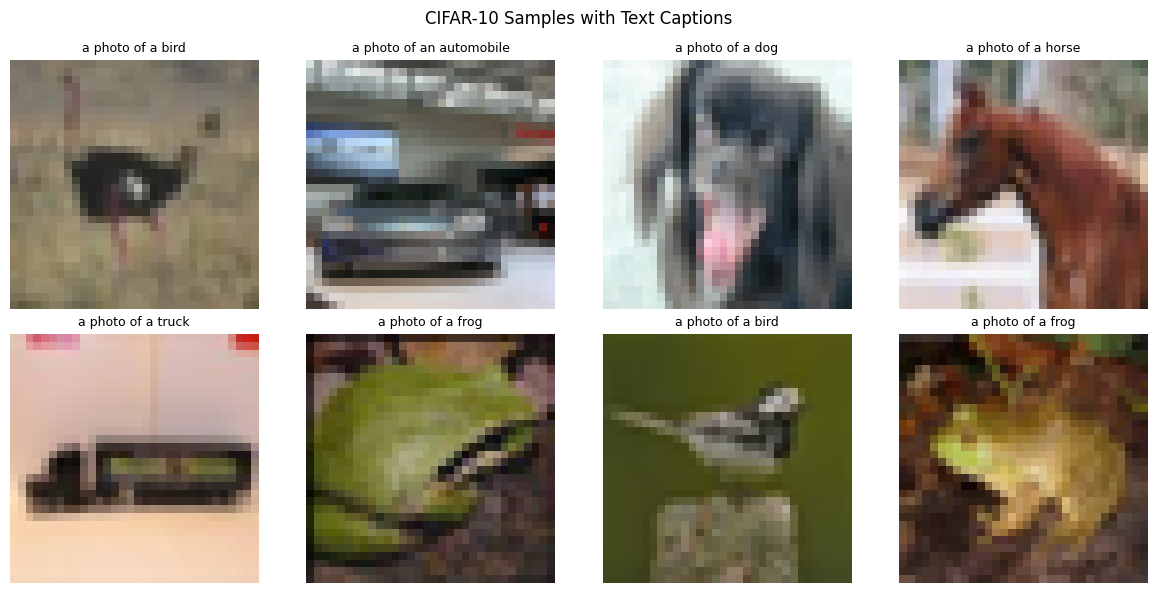

In [9]:
# Visualize samples with their captions
images, labels = next(iter(train_loader))
captions = make_cifar10_captions(labels[:8])

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, (ax, img, caption) in enumerate(zip(axes.flat, images[:8], captions)):
    # Denormalize
    img = (img + 1) / 2
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(caption, fontsize=9)
    ax.axis('off')

plt.suptitle('CIFAR-10 Samples with Text Captions', fontsize=12)
plt.tight_layout()
plt.show()

## Step 5: Classifier-Free Guidance for Text

CFG works the same way as before, but with text embeddings.

### The CFG Formula (Same as Before)

$$v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$$

where:
- $v_{\text{cond}} = v_\theta(x_t, t, Z_{\text{text}})$. Velocity with text embedding
- $v_{\text{uncond}} = v_\theta(x_t, t, Z_{\text{null}})$. Velocity with null text
- $w$. Guidance scale

### What is Null Text?

The "null text" is an empty string encoded by CLIP:

$$Z_{\text{null}} = \text{CLIP}("") \in \mathbb{R}^{M \times D}$$

This represents "no specific content" - similar to the null class in the previous notebook.

### Text Dropout During Training

To enable CFG, we randomly replace text embeddings with null:

$$Z_{\text{train}} = \begin{cases}
\text{CLIP}(\text{prompt}) & \text{w.p. } 1 - p_{\text{drop}} \\
\text{CLIP}("") & \text{w.p. } p_{\text{drop}}
\end{cases}$$

Typically $p_{\text{drop}} = 0.1$ (10%).

### Guidance Scale: Text vs Class

| Conditioning | Typical Scale | Reason |
|--------------|---------------|--------|
| Class | 3-5 | Simple, direct mapping |
| Text | 7-10 | Complex, needs stronger push |

Text conditioning is more nuanced - higher guidance pushes toward the most "on-prompt" outputs.

In [10]:
# Compare text embedding vs null embedding
_, text_emb = text_encoder.encode(["a photo of a cat"], return_pooled=True)
_, null_emb = text_encoder.encode([""], return_pooled=True)

# Compute similarity
text_norm = text_emb / text_emb.norm(dim=-1, keepdim=True)
null_norm = null_emb / null_emb.norm(dim=-1, keepdim=True)
similarity = (text_norm @ null_norm.mT).item()

print(f"Text embedding shape: {text_emb.shape}")
print(f"Null embedding shape: {null_emb.shape}")
print(f"Cosine similarity: {similarity:.3f}")
print(f"\nThe null embedding is different from any real text embedding.")
print(f"This makes CFG work: we can push away from 'nothing' toward 'something'.")

Text embedding shape: torch.Size([1, 512])
Null embedding shape: torch.Size([1, 512])
Cosine similarity: 0.653

The null embedding is different from any real text embedding.
This makes CFG work: we can push away from 'nothing' toward 'something'.


## Step 6: Training the Text-Conditional DiT

Training follows the same flow matching objective, now with text conditioning.

### Training Algorithm

For each batch of (image, label) pairs:

1. **Convert labels to captions**: $y \to \text{"a photo of a "} + \text{class\_name}$
2. **Encode with CLIP**: $\text{caption} \to Z \in \mathbb{R}^{M \times D}$
3. **Apply text dropout**: With 10% probability, $Z \leftarrow Z_{\text{null}}$
4. **Sample noise and time**: $x_1 \sim \mathcal{N}(0, I)$, $t \sim \text{Uniform}(0, 1)$
5. **Interpolate**: $x_t = (1-t) x_0 + t x_1$
6. **Predict velocity**: $\hat{v} = v_\theta(x_t, t, Z)$
7. **Compute loss**: $\mathcal{L} = \|\hat{v} - (x_1 - x_0)\|^2$

### Loss Function

$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t, Z}\left[ \| v_\theta(x_t, t, Z) - (x_1 - x_0) \|^2 \right]$$

In [11]:
from from_noise_to_images.train import TextConditionalTrainer

# Create the trainer
trainer = TextConditionalTrainer(
    model=model,
    text_encoder=text_encoder,
    dataloader=train_loader,
    caption_fn=make_cifar10_captions,
    lr=1e-4,
    weight_decay=0.01,
    text_drop_prob=0.1,  # 10% text dropout for CFG
    device=device,
)

print("Training Text-Conditional DiT with CFG text dropout...")
print("(10% of samples trained with null text)\n")

NUM_EPOCHS = 30
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training Text-Conditional DiT with CFG text dropout...
(10% of samples trained with null text)

Training on cuda
Model parameters: 18,145,072
CFG text dropout: 10%


Epoch 1/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 1: avg_loss = 0.5523


Epoch 2/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 2: avg_loss = 0.2997


Epoch 3/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 3: avg_loss = 0.2784


Epoch 4/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 4: avg_loss = 0.2652


Epoch 5/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 5: avg_loss = 0.2580


Epoch 6/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 6: avg_loss = 0.2498


Epoch 7/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 7: avg_loss = 0.2432


Epoch 8/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 8: avg_loss = 0.2403


Epoch 9/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 9: avg_loss = 0.2353


Epoch 10/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 10: avg_loss = 0.2328


Epoch 11/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 11: avg_loss = 0.2282


Epoch 12/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 12: avg_loss = 0.2248


Epoch 13/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 13: avg_loss = 0.2215


Epoch 14/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 14: avg_loss = 0.2208


Epoch 15/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 15: avg_loss = 0.2188


Epoch 16/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 16: avg_loss = 0.2165


Epoch 17/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 17: avg_loss = 0.2148


Epoch 18/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 18: avg_loss = 0.2122


Epoch 19/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 19: avg_loss = 0.2111


Epoch 20/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 20: avg_loss = 0.2098


Epoch 21/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 21: avg_loss = 0.2073


Epoch 22/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 22: avg_loss = 0.2056


Epoch 23/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 23: avg_loss = 0.2042


Epoch 24/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 24: avg_loss = 0.2037


Epoch 25/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 25: avg_loss = 0.2032


Epoch 26/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 26: avg_loss = 0.2025


Epoch 27/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 27: avg_loss = 0.2016


Epoch 28/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 28: avg_loss = 0.2009


Epoch 29/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 29: avg_loss = 0.2013


Epoch 30/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 30: avg_loss = 0.1993


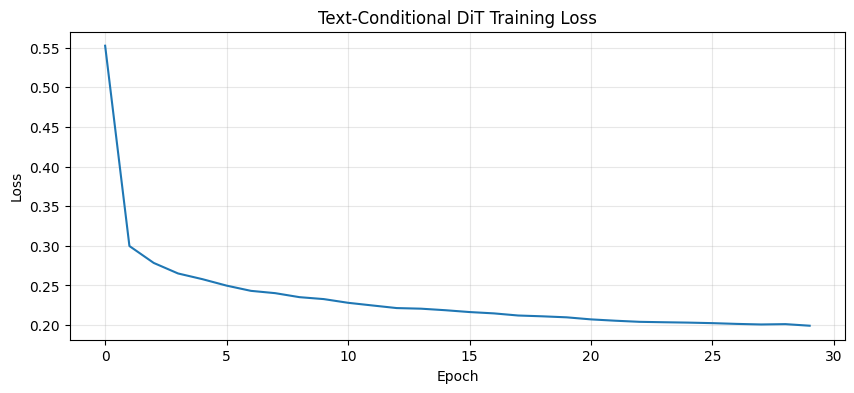

Final loss: 0.1993


In [12]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Text-Conditional DiT Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")

## Step 7: Sampling with Text Prompts

Now the exciting part - generating images from text!

### CFG Sampling Algorithm

```
Input: Trained model v_θ, text prompt, guidance scale w, num_steps N

1. Encode text: Z_text = CLIP(prompt)
2. Encode null: Z_null = CLIP("")
3. Sample x_1 ~ N(0, I)  # Pure noise
4. dt = 1/N

For t = 1, 1-dt, ..., dt:
    v_cond = v_θ(x_t, t, Z_text)    # With text
    v_uncond = v_θ(x_t, t, Z_null)  # Without text
    v_guided = v_uncond + w × (v_cond - v_uncond)  # CFG
    x_t ← x_t - dt × v_guided       # Euler step

Return x_0  # Generated image
```

Generating images for each class with CFG scale=7.5...


Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

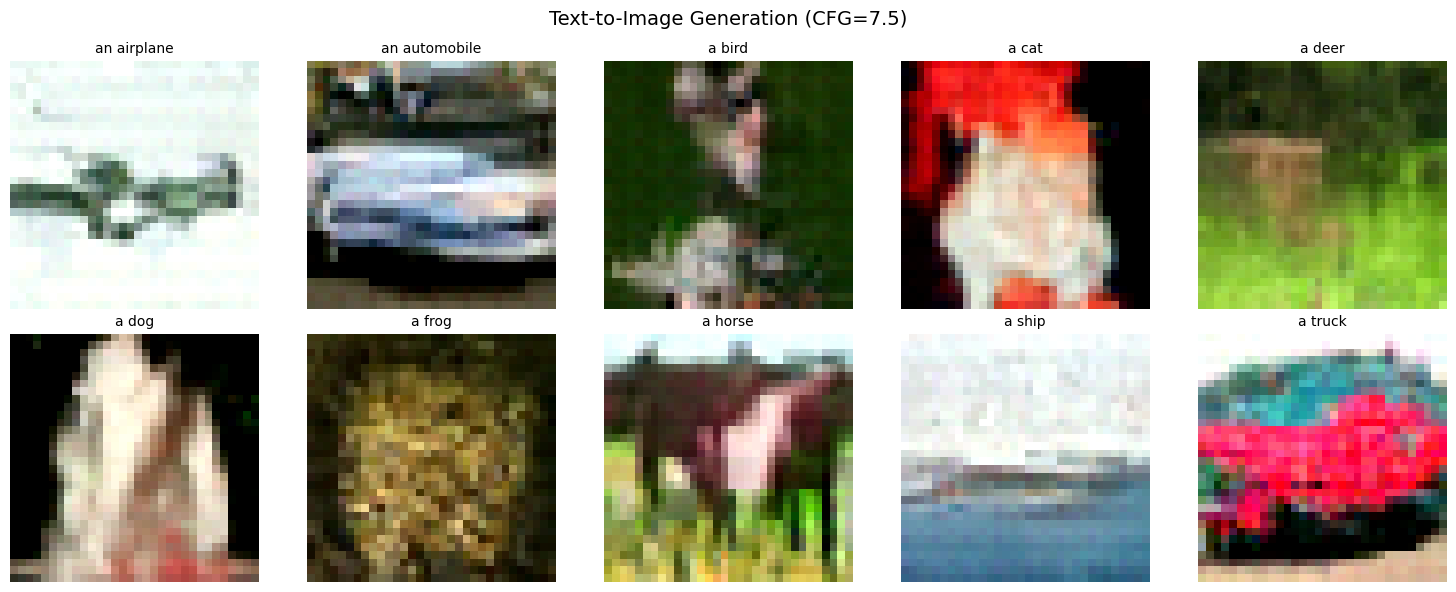

In [13]:
from from_noise_to_images.sampling import sample_text_conditional

model.eval()

# Generate images for each CIFAR-10 class
prompts = [
    "a photo of an airplane",
    "a photo of an automobile",
    "a photo of a bird",
    "a photo of a cat",
    "a photo of a deer",
    "a photo of a dog",
    "a photo of a frog",
    "a photo of a horse",
    "a photo of a ship",
    "a photo of a truck",
]

print("Generating images for each class with CFG scale=7.5...")

samples = sample_text_conditional(
    model=model,
    text_encoder=text_encoder,
    prompts=prompts,
    image_shape=(3, 32, 32),
    num_steps=50,
    cfg_scale=7.5,
    device=device,
)

# Display results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (ax, prompt) in enumerate(zip(axes.flat, prompts)):
    img = (samples[i] + 1) / 2  # Denormalize
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(prompt.replace('a photo of ', ''), fontsize=10)
    ax.axis('off')

plt.suptitle('Text-to-Image Generation (CFG=7.5)', fontsize=14)
plt.tight_layout()
plt.show()

Comparing CFG scales for: 'a photo of a cat'


Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

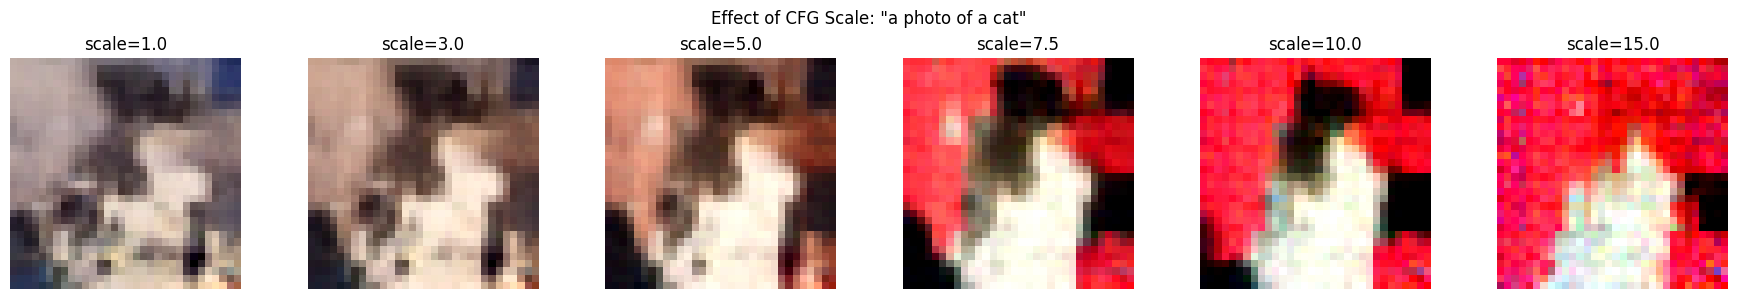


Observations:
  scale=1.0: No guidance, blurry
  scale=3-5: Mild guidance, improving
  scale=7-10: Good balance
  scale=15+: May oversaturate


In [14]:
# Compare different CFG scales
test_prompt = "a photo of a cat"
cfg_scales = [1.0, 3.0, 5.0, 7.5, 10.0, 15.0]

print(f"Comparing CFG scales for: '{test_prompt}'")

fig, axes = plt.subplots(1, len(cfg_scales), figsize=(18, 3))

for ax, scale in zip(axes, cfg_scales):
    # Use same seed for fair comparison
    torch.manual_seed(42)
    
    sample = sample_text_conditional(
        model=model,
        text_encoder=text_encoder,
        prompts=[test_prompt],
        image_shape=(3, 32, 32),
        num_steps=50,
        cfg_scale=scale,
        device=device,
    )
    
    img = (sample[0] + 1) / 2
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(f'scale={scale}')
    ax.axis('off')

plt.suptitle(f'Effect of CFG Scale: "{test_prompt}"', fontsize=12)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("  scale=1.0: No guidance, blurry")
print("  scale=3-5: Mild guidance, improving")
print("  scale=7-10: Good balance")
print("  scale=15+: May oversaturate")

Testing compositional understanding...
(Results may be limited by CIFAR-10 training data)



Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

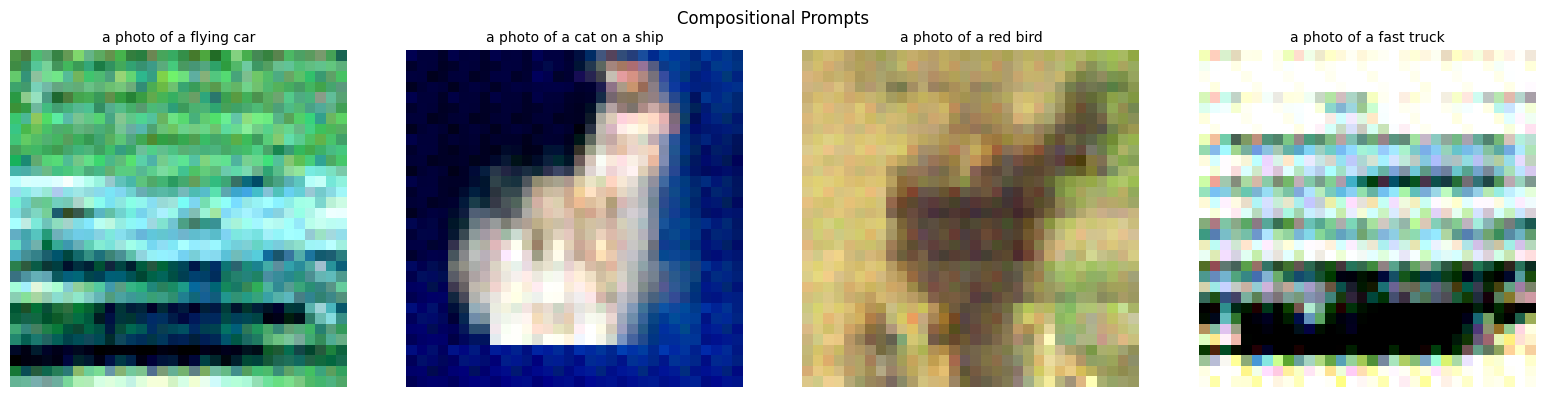

In [15]:
# Try some creative prompts
creative_prompts = [
    "a photo of a flying car",
    "a photo of a cat on a ship",
    "a photo of a red bird",
    "a photo of a fast truck",
]

print("Testing compositional understanding...")
print("(Results may be limited by CIFAR-10 training data)\n")

torch.manual_seed(123)
creative_samples = sample_text_conditional(
    model=model,
    text_encoder=text_encoder,
    prompts=creative_prompts,
    image_shape=(3, 32, 32),
    num_steps=50,
    cfg_scale=7.5,
    device=device,
)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, prompt, sample in zip(axes, creative_prompts, creative_samples):
    img = (sample + 1) / 2
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(prompt, fontsize=10)
    ax.axis('off')

plt.suptitle('Compositional Prompts', fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
# Save the trained model
trainer.save_checkpoint("phase4_text_conditional_dit.pt")
print("Model saved to phase4_text_conditional_dit.pt")

Model saved to phase4_text_conditional_dit.pt


## Summary: Text-to-Image Generation

We extended the DiT to accept natural language prompts via CLIP and cross-attention.

### Key Equations

| Concept | Equation |
|---------|----------|
| CLIP encoding | $Z = \text{CLIP}(\text{text}) \in \mathbb{R}^{M \times D}$ |
| Cross-attention | $\text{CrossAttn}(X, Z) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d}}\right) V$ |
| Queries | $Q = X W_Q$ (from image patches) |
| Keys, Values | $K = Z W_K$, $V = Z W_V$ (from text tokens) |
| Training loss | $\mathcal{L} = \mathbb{E}[\|v_\theta(x_t, t, Z) - v\|^2]$ |
| CFG formula | $v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$ |
| Null text | $Z_{\text{null}} = \text{CLIP}("")$ |

### Cross-Attention Details

The attention matrix $A \in \mathbb{R}^{N \times M}$:
- $N$ = number of image patches
- $M$ = number of text tokens

$$A_{ij} = \frac{\exp(q_i \cdot k_j / \sqrt{d})}{\sum_{j'} \exp(q_i \cdot k_{j'} / \sqrt{d})}$$

$A_{ij}$ answers: "How much should image patch $i$ attend to text token $j$?"

### Architecture Comparison

| Notebook | Model | Conditioning | Mechanism |
|----------|-------|-------------|------------|
| 01-02 | DiT | None | - |
| 03 | ConditionalDiT | Class labels | $c = h_t + e(y)$, adaLN |
| 04 | TextConditionalDiT | Text prompts | Cross-attention to CLIP |

## What's Next

In the next notebook, we add **latent space diffusion** with a VAE:

| Current (Pixel Space) | Next (Latent Space) |
|----------------------|---------------------|
| Diffusion on 32×32×3 | Diffusion on 4×4×4 latent |
| 3,072 dimensions | 64 dimensions (48× smaller) |
| Limited resolution | Scales to 256×256+ |

This is how Stable Diffusion achieves high-resolution generation!